In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.optim.lr_scheduler import ExponentialLR, StepLR
from drawnow import drawnow, figure
import matplotlib.pyplot as plt
import sklearn
import random
import argparse
import numpy as np
from itertools import count
import csv

In [ ]:
def solar_perts(t):
    T=7
    mu = 50
    m0=0
    m1 = (T*mu)/(T/2)**2
    m2 = (-mu)/(T/2)**2
    mean_ = 0
    s = 0.5
    std_norm = np.exp(mean_ + s * np.random.randn())
    return m0+(m1*t)+(m2*(t**2)) + std_norm

In [4]:
#read csv to list: solar perturbations

solar_perturbations = []
with open("GFG_1.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
    for row in reader: # each row is a list
        solar_perturbations.append(row)


In [5]:
parser = argparse.ArgumentParser(description='PyTorch A2C for Decentralised energy storage system')
parser.add_argument('-f')
parser.add_argument('--gamma', type=float, default=0.9)
#parser.add_argument('--solarPowerMax', type=float, default=np.max(solar_perturbations))
parser.add_argument('--powerMax', type=float, default=600)
parser.add_argument('--powerMin', type=float, default=0)
parser.add_argument('--b_node1', type=float, default=8)
parser.add_argument('--b_node2', type=float, default=7)
parser.add_argument('--b_node3', type=float, default=6)
parser.add_argument('--rewardScale_node1', type=float, default=0.0001)
parser.add_argument('--rewardScale_node2', type=float, default=0.0001)
parser.add_argument('--rewardScale_node3', type=float, default=0.0001)
parser.add_argument('--actor_lr_node1', type=float, default=1e-5)
parser.add_argument('--critic_lr_node1', type=float, default=7e-5)
parser.add_argument('--actor_lr_node2', type=float, default=1e-5)
parser.add_argument('--critic_lr_node2', type=float, default=7e-5)
parser.add_argument('--actor_lr_node3', type=float, default=1e-5)
parser.add_argument('--critic_lr_node3', type=float, default=7e-5)

parser.add_argument('--max_tvol_tnode12', type=float, default=100)
parser.add_argument('--max_tvol_tnode13', type=float, default=100)
parser.add_argument('--max_tvol_tnode23', type=float, default=100)
parser.add_argument('--rewardScale_tnode12', type=float, default=.001)
parser.add_argument('--rewardScale_tnode13', type=float, default=.001)
parser.add_argument('--rewardScale_tnode23', type=float, default=.001)
parser.add_argument('--actor_lr_tnode12', type=float, default=1e-5)
parser.add_argument('--critic_lr_tnode12', type=float, default=7e-5)
parser.add_argument('--actor_lr_tnode13', type=float, default=1e-5)
parser.add_argument('--critic_lr_tnode13', type=float, default=7e-5)
parser.add_argument('--actor_lr_tnode23', type=float, default=1e-5)
parser.add_argument('--critic_lr_tnode23', type=float, default=7e-5)
parser.add_argument('--max_episode', type=int, default=400000)
parser.add_argument('--TUpdate', type=int, default=200)
        
cfg = parser.parse_args()
    
#for the moving average plot
last_score_plot = [0]
avg_score_plot = [0]

Demand_max = [200,180,250,300,350,450,500,400]
            
def draw_fig():
    plt.title('reward')
    plt.plot(last_score_plot, '-')
    plt.plot(avg_score_plot, 'r-')

In [6]:
def rescale_action(val,lb,ub):
    return val * (ub- lb) / 2 +(lb + ub) / 2

def cost_func_node1(x):
    return -(0.02*(x**2)+2*x+20)

def cost_func_node2(x):
    return -(0.05*(x**2)+10*x+40)

def cost_func_node3(x):
    return -(0.07*(x**2)+20*x+60)

def invDemand_curve(Q,a,b):
    price = (a/b)-(Q/b) #linear
    return price

def consumerSurplus(price,Q,a,b):
    #linear
    pmax = (a/b)
    area = 0.5*(pmax-price)*(Q)
    return area

In [ ]:
class Environment(object):
    def __init__(self,cost_func_node1,cost_func_node2,cost_func_node3,invDemand_curve,consumerSurplus,nb_interval,Demand_max):
        self.cost_func_node1 = cost_func_node1
        self.cost_func_node2 = cost_func_node2
        self.cost_func_node3 = cost_func_node3
        self.invDemand_curve = invDemand_curve
        self.consumerSurplus = consumerSurplus
        self.nb_interval = nb_interval
        self.Demand_max = Demand_max
        #self.solar_perturbations = solar_perturbations

    def sample_state_space_node(self):
        battery_state = np.random.uniform(0, 280)
        load_state = random.choice(self.Demand_max)
        return np.array([battery_state,load_state],dtype=np.float32)
    
    def sample_state_space_tnode(self): #can use same func for tnode13
        battery_state1 = np.random.uniform(0, 280) #X1
        load_state1 = random.choice(self.Demand_max)
        battery_state2 = np.random.uniform(0, 280)
        load_state2 = random.choice(self.Demand_max)
        return np.array([battery_state1,load_state1,
                         battery_state2,load_state2],dtype=np.float32)

    def reset(self):
        self.solar_node1 = solar_perts(0)
        self.solar_node2 = solar_perts(0)
        self.solar_node3 = solar_perts(0)
        self.time_interval = 0
        self.battery_node1 = 0.0
        self.battery_node2 = 0.0
        self.battery_node3 = 0.0
        self.state_node1 = np.array([self.battery_node1,self.Demand_max[0]])
        self.state_node2 = np.array([self.battery_node2,self.Demand_max[0]])
        self.state_node3 = np.array([self.battery_node3,self.Demand_max[0]])
        self.state_tnode12 = np.array([self.battery_node1,self.Demand_max[0],
                                       self.battery_node2,self.Demand_max[0]])
        self.state_tnode13 = np.array([self.battery_node1,self.Demand_max[0],
                                       self.battery_node3,self.Demand_max[0]])
        self.state_tnode23 = np.array([self.battery_node2,self.Demand_max[0],
                                       self.battery_node3,self.Demand_max[0]])
        return self.state_node1,self.state_node2,self.state_node3,self.state_tnode12,self.state_tnode13,self.state_tnode23
    
    #given actions, get next state, reward
    def action_to_feasible(self,action_node1,action_node2,action_node3,
                           action_tnode12,action_tnode13,action_tnode23):
        t = self.time_interval
        #print('time',t)
        #print('SoC',self.battery_node1)
        
        a_ = Demand_max[t]
        b_node1 = cfg.b_node1
        b_node2 = cfg.b_node2
        b_node3 = cfg.b_node3
            
        price_max_node1 = a_ / b_node1
        D_min_node1 = a_ - (b_node1*price_max_node1)
        
        price_max_node2 = a_ / b_node2
        D_min_node2 = a_ - (b_node2*price_max_node2)
        
        price_max_node3 = a_ / b_node3
        D_min_node3 = a_ - (b_node3*price_max_node3)
        
        D_max = a_
        
        #print('a',a_,'b',b_,'dmin',D_min,'dmax',D_max)
        ###T-NODE 12###
        tvol12 = action_tnode12[0].item()
        tvol12 = rescale_action(tvol12,0,cfg.max_tvol_tnode12)
        #print('tvol12',tvol12)
        
        tvol13 = action_tnode13[0].item()
        tvol13 = rescale_action(tvol13,0,cfg.max_tvol_tnode13)
        #print('tvol13',tvol13)
        
        tvol23 = action_tnode23[0].item()
        tvol23 = rescale_action(tvol23,0,cfg.max_tvol_tnode23)
        #print('tvol23',tvol23)

        
        #####get action######
        ####NODE 1####
        pb_node1 = action_node1[0].item()
        pb_node1 = rescale_action(pb_node1,-200,200)
        #print('pb_node1',pb_node1)
        r_price_node1 = action_node1[1].item()
        r_price_node1 = rescale_action(r_price_node1,0,62.5)
        #print('price_node1',price_node1)
        
        ####NODE 2####
        pb_node2 = action_node2[0].item()
        pb_node2 = rescale_action(pb_node2,-200,200)
        #print('pb_node2',pb_node2)
        r_price_node2 = action_node2[1].item()
        r_price_node2 = rescale_action(r_price_node2,0,71.42) #change this
        
        ####NODE 2####
        pb_node3 = action_node3[0].item()
        pb_node3 = rescale_action(pb_node3,-200,200)
        #print('pb_node3',pb_node3)
        r_price_node3 = action_node3[1].item()
        r_price_node3 = rescale_action(r_price_node3,0,83.33) #change this

        #####Reward computation######
        #balance eqn, P= D +P_b + T_send - T_receive - solar
        #battery bounds based on SoC
        misc = tvol12+tvol13- self.solar_node1
        charge_bound_node1 = min(200,(280-self.battery_node1))
        discharge_bound_node1 = max(-200,-self.battery_node1)
        #print('battery bounds based on SoC',charge_bound_node1,discharge_bound_node1)
        f_pb_node1 = min(max(pb_node1,discharge_bound_node1 ),charge_bound_node1) #feasible action
        #print('f_pb_node1',f_pb_node1)
        
        assert f_pb_node1 >=-200, f"f_pb_node1 < -200,{f_pb_node1,discharge_bound_node1,charge_bound_node1,self.battery_node1}"
        assert f_pb_node1 <=200, f"f_pb_node1 >200,{f_pb_node1,discharge_bound_node1,charge_bound_node1,self.battery_node1}"
        
        ub_price = min(max((a_ + f_pb_node1+(misc))/b_node1,0), price_max_node1)
        lb_price = max((a_ + f_pb_node1+(misc)-cfg.powerMax)/b_node1, 0)
        f_price_node1 = min(max(r_price_node1,lb_price),ub_price)
        #print('ub_price',ub_price,'lb_price',lb_price,'f_price_node1',f_price_node1)
        
        assert f_price_node1 >=0, f"f_price_node1 < 0,{f_price_node1,ub_price,lb_price}"
        assert f_price_node1 <=price_max_node1, f"f_price_node1 >price_max,{f_price_node1,ub_price,lb_price}"
        
        demand_node1 = a_-(b_node1*f_price_node1)
        #print('demand_node1',demand_node1)
        prod_min = cfg.powerMin
        prod_max = cfg.powerMax
        r_power_node1 = demand_node1 + f_pb_node1 + misc
        #print('prod_min',prod_min,'prod_max',prod_max)
        f_power_node1 = min(max(r_power_node1,prod_min),prod_max)
        #print('power_node1',r_power_node1,'f_power_node',f_power_node1)
        
        assert demand_node1 >=D_min_node1, f"demand_node1 < D_min,{demand_node1}"
        assert demand_node1 <=D_max, f"demand_node1 > D_max,{demand_node1}"

        cost_node1 = self.cost_func_node1(f_power_node1) #neg cost
        cs_node1 = consumerSurplus(f_price_node1,demand_node1,a_,b_node1)
        #print('cost_node1',cost_node1,'cs_node1',cs_node1)

        #feasible region penalty for node 1
        #penalty_node1 = (abs(f_pb_node1-pb_node1)*50)+abs(f_power_node1-power_node1)+(abs(f_price_node1-price_node1)*1)
        batt_penalty = -(abs(f_pb_node1-pb_node1)**2)
        dem_penalty = -(abs(f_price_node1-r_price_node1)**2)*20
        pow_penalty = -(abs(f_power_node1-r_power_node1)**1)
        
        reward_node1 = cs_node1+cost_node1 +batt_penalty+dem_penalty+pow_penalty
        #print('reward_node1',reward_node1)
        
        #store info
        path_n1.append([self.solar_node1,pb_node1,f_pb_node1,r_power_node1,f_power_node1,demand_node1,r_price_node1,f_price_node1,
                        reward_node1,cost_node1,cs_node1,batt_penalty,dem_penalty,pow_penalty])

        ####NODE 2####
        #balance eqn, P+P_b = D + T_send - T_receive - solar
        #battery bounds based on SoC
        misc = tvol23-tvol12- self.solar_node2
        charge_bound_node2 = min(200,(280-self.battery_node2))
        discharge_bound_node2 = max(-200,-self.battery_node2)
        discharge_bound_node2 = max(-(D_max+misc),discharge_bound_node2)
        #print('battery bounds based on SoC',charge_bound_node2,discharge_bound_node2)
        f_pb_node2 = min(max(pb_node2,discharge_bound_node2 ),charge_bound_node2) #feasible action
        #print('f_pb_node2',f_pb_node2)
        assert f_pb_node2 >=-200, f"f_pb_node2 < -200,{f_pb_node2,discharge_bound_node2,charge_bound_node2,self.battery_node2}"
        assert f_pb_node2 <=200, f"f_pb_node2 > 200,{f_pb_node2,discharge_bound_node2,charge_bound_node2,self.battery_node2}"
        
        
        max_price = min(max((a_ + f_pb_node2+(misc))/b_node2,0), price_max_node2)
        min_price = max((a_ + f_pb_node2+(misc)-cfg.powerMax)/b_node2, 0)
        f_price_node2 = min(max(r_price_node2,min_price),max_price)
        #print('max_price',max_price,'f_price_node2',f_price_node2)
        assert f_price_node2 >=0, f"f_price_node2 < 0,{f_price_node2,max_price,min_price}"
        assert f_price_node2 <=price_max_node2, f"f_price_node2 >price_max,{f_price_node2,max_price,min_price}"
        
        demand_node2 = a_-(b_node2*f_price_node2)
        #print('demand_node2',demand_node2)
        prod_min = cfg.powerMin
        prod_max = cfg.powerMax
        r_power_node2 = demand_node2 + f_pb_node2 + misc
        #print('prod_min',prod_min,'prod_max',prod_max)
        f_power_node2 = min(max(r_power_node2,prod_min),prod_max)
        #print('power_node2',power_node2,'f_power_node',f_power_node2)
        
        assert demand_node2 >=D_min_node2, f"demand_node2 < D_min,{demand_node2}"
        assert demand_node2 <=D_max, f"demand_node2 > D_max,{demand_node2}"

        cost_node2 = self.cost_func_node2(f_power_node2) #neg cost
        cs_node2 = consumerSurplus(f_price_node2,demand_node2,a_,b_node2)
        #print('cost_node2',cost_node2,'cs_node2',cs_node2)

        #feasible region penalty for node 1
        batt_penalty = -(abs(f_pb_node2-pb_node2)**2)
        dem_penalty = -(abs(f_price_node2-r_price_node2)**2)*10
        pow_penalty = -(abs(f_power_node2-r_power_node2)**1)
        
        reward_node2 = cs_node2+cost_node2+batt_penalty+dem_penalty+pow_penalty
        #print('reward_node2',reward_node2)
        
        #store info
        path_n2.append([self.solar_node2,pb_node2,f_pb_node2,r_power_node2,f_power_node2,demand_node2,r_price_node2,f_price_node2,
                        reward_node2,cost_node2,cs_node2,batt_penalty,dem_penalty,pow_penalty])
        
        ####NODE 3####
        #balance eqn, P= D +P_b  + T_send - T_receive - solar
        misc = -tvol23 - tvol13 - self.solar_node3
        charge_bound_node3 = min(200,(280-self.battery_node3))
        discharge_bound_node3 = max(-200,-self.battery_node3)
        discharge_bound_node3 =  max(-(D_max+misc),discharge_bound_node3)
        #print('battery bounds based on SoC',charge_bound_node3,discharge_bound_node3)
        f_pb_node3 = min(max(pb_node3,discharge_bound_node3 ),charge_bound_node3) #feasible action
        #more feasibility for battery:
        #print('f_pb_node3',f_pb_node3)
        assert f_pb_node3 >=-200, f"f_pb_node2 < -50,{f_pb_node3,discharge_bound_node3,charge_bound_node3,self.battery_node3}"
        assert f_pb_node3 <=200, f"f_pb_node2 > 50,{f_pb_node3,discharge_bound_node3,charge_bound_node3,self.battery_node3}"
        
        
        max_price = min(max((a_ + f_pb_node3+(misc))/b_node3,0), price_max_node3) #ensure price is positive
        min_price = max((a_ + f_pb_node3+(misc)-cfg.powerMax)/b_node3, 0)
        f_price_node3 = min(max(r_price_node3,min_price),max_price)
        #print('max_price',max_price,'f_price_node2',f_price_node2)
        assert f_price_node3 >=0, f"f_price_node3 < 0,{f_price_node3,max_price,min_price}"
        assert f_price_node3 <=price_max_node3, f"f_price_node3 >price_max,{f_price_node3,max_price,min_price}"
        
        demand_node3 = a_-(b_node3*f_price_node3)
        #print('demand_node3',demand_node3)
        prod_min = cfg.powerMin
        prod_max = cfg.powerMax
        r_power_node3 = demand_node3 + f_pb_node3 + misc
        #print('prod_min',prod_min,'prod_max',prod_max)
        f_power_node3 = min(max(r_power_node3,prod_min),prod_max)
        #print('power_node2',power_node2,'f_power_node',f_power_node2)
        
        assert demand_node3 >=D_min_node3, f"demand_node3 < D_min,{demand_node3}"
        assert demand_node3 <=D_max, f"demand_node3 > D_max,{demand_node3}"

        cost_node3 = self.cost_func_node3(f_power_node3) #neg cost
        cs_node3 = consumerSurplus(f_price_node3,demand_node3,a_,b_node3)
        #print('cost_node2',cost_node2,'cs_node2',cs_node2)

        #feasible region penalty for node 1
        #penalty_node3 = (abs(f_pb_node3-pb_node3)*1000)+abs(f_power_node3-power_node3)+(abs(f_price_node3-price_node3)*10000)
        batt_penalty = -(abs(f_pb_node3-pb_node3)**2)
        dem_penalty = -(abs(f_price_node3-r_price_node3)**2)*10
        pow_penalty = -(abs(f_power_node3-r_power_node3)**2)

        reward_node3 = cs_node3+cost_node3+batt_penalty+dem_penalty+pow_penalty
        #print('reward_node3',reward_node3)
        
        #store info
        path_n3.append([self.solar_node3,pb_node3,f_pb_node3,r_power_node3,f_power_node3,demand_node3,r_price_node3,f_price_node3,
                        reward_node3,cost_node3,cs_node3,batt_penalty,dem_penalty,pow_penalty])
        ###T-NODE 12###
        reward_node12 = -(f_price_node1-f_price_node2)**2
        #print('reward_node12=',reward_node12)
        ###T-NODE 13###
        reward_node13 = -(f_price_node1-f_price_node3)**2
        #print('reward_node13=',reward_node13)
        ###T-NODE 23###
        reward_node23 = -(f_price_node2-f_price_node3)**2
        #print('reward_node23=',reward_node23)
        
        #store info
        path_tn12.append([tvol12,reward_node12])
        path_tn13.append([tvol13,reward_node13])
        path_tn23.append([tvol23,reward_node23])

        return [[f_pb_node1,f_pb_node2,f_pb_node3],[f_price_node1,f_price_node2,f_price_node3],
                [f_power_node1,f_power_node2,f_power_node3],
                [reward_node1,reward_node2,reward_node3,reward_node12,reward_node13,reward_node23]]
        

    def step(self,action_node1,action_node2,action_node3,action_tnode12,action_tnode13,action_tnode23):
        battery_charges,prices,powervals,rewards_ = self.action_to_feasible(action_node1,action_node2,action_node3,
                                                                            action_tnode12,action_tnode13,action_tnode23)
        f_pb_node1 = battery_charges[0]
        f_pb_node2 = battery_charges[1]
        f_pb_node3 = battery_charges[2]
        
        f_price_node1 = prices[0]
        f_price_node2 = prices[1]
        f_price_node3 = prices[2]
        
        f_power_node1 = powervals[0]
        f_power_node2 = powervals[1]
        f_power_node3 = powervals[2]
        
        #SCALE REWARD
        reward_node1 = rewards_[0]* cfg.rewardScale_node1
        reward_node2 = rewards_[1]* cfg.rewardScale_node2
        reward_node3 = rewards_[2]* cfg.rewardScale_node3
        reward_node12 = rewards_[3]* cfg.rewardScale_tnode12 
        reward_node13 = rewards_[4]* cfg.rewardScale_tnode13 
        reward_node23 = rewards_[5]* cfg.rewardScale_tnode23

        #print('scaled rew=',reward_)
        #next state transition
        if self.time_interval == self.nb_interval -1:
            path_n1b.append([self.battery_node1+f_pb_node1]) #to print values in results
            path_n2b.append([self.battery_node2+f_pb_node2]) #to print values in results
            path_n3b.append([self.battery_node3+f_pb_node3]) #to print values in results
            self.reset()
            states=[self.state_node1,self.state_node2,self.state_node3,self.state_tnode12,self.state_tnode13,self.state_tnode23]
            #scaled rewards
            rewards_ = [reward_node1,reward_node2,reward_node3,reward_node12,reward_node13,reward_node23]
            return states,rewards_,self.time_interval,True
        else:
            self.battery_node1 = self.battery_node1+f_pb_node1
            self.battery_node2 = self.battery_node2+f_pb_node2
            self.battery_node3 = self.battery_node3+f_pb_node3
            path_n1b.append([self.battery_node1])
            path_n2b.append([self.battery_node2])
            path_n3b.append([self.battery_node3])
            self.time_interval += 1
            self.solar_node1 = solar_perts(self.time_interval)
            self.solar_node2 = solar_perts(self.time_interval)
            self.solar_node3 = solar_perts(self.time_interval)
            self.state_node1 = np.array([self.battery_node1,self.Demand_max[self.time_interval]])
            self.state_node2 = np.array([self.battery_node2,self.Demand_max[self.time_interval]])
            self.state_node3 = np.array([self.battery_node3,self.Demand_max[self.time_interval]])

            self.state_tnode12 = np.array([self.battery_node1,self.Demand_max[self.time_interval],
                                           self.battery_node2,self.Demand_max[self.time_interval]])
            self.state_tnode13 = np.array([self.battery_node1,self.Demand_max[self.time_interval],
                                           self.battery_node3,self.Demand_max[self.time_interval]])
            self.state_tnode23 = np.array([self.battery_node2,self.Demand_max[self.time_interval],
                                           self.battery_node3,self.Demand_max[self.time_interval]])

            #to return
            states=[self.state_node1,self.state_node2,self.state_node3,self.state_tnode12,self.state_tnode13,self.state_tnode23]
            #scaled rewards
            rewards_ = [reward_node1,reward_node2,reward_node3,reward_node12,reward_node13,reward_node23]
            return states,rewards_,self.time_interval,False


In [ ]:
#actor with single continuous action
class Actor(nn.Module):
    def __init__(self,state_dim,action_dim):
        super(Actor, self).__init__()
        self.layer1 = nn.Linear(state_dim, 40)
        self.pb_mu = nn.Linear(40, action_dim)
        self.pb_sigma = nn.Linear(40,action_dim)
        init.xavier_normal_(self.layer1.weight)
        init.xavier_normal_(self.pb_mu.weight)
        init.xavier_normal_(self.pb_sigma.weight)


    def forward(self, x):
        y = F.relu(self.layer1(x))
        mu = self.pb_mu(y)
        sigma = F.softplus(self.pb_sigma(y)) + 1e-5
        return mu, sigma

class Critic(nn.Module):
    def __init__(self,state_dim):
        super(Critic, self).__init__()
        self.fc2 = nn.Linear(state_dim, 40)         #(state,hidden1)
        self.critic_fc = nn.Linear(40, 40)   #(hidden1,hidden2)
        self.critic_out = nn.Linear(40, 1)    #(hidden2,op)
        init.xavier_normal_(self.fc2.weight)
        init.xavier_normal_(self.critic_fc.weight)
        init.xavier_normal_(self.critic_out.weight)

    def forward(self, x):
        x = F.relu(self.fc2(x))
        value = self.critic_out(F.relu(self.critic_fc(x)))
        return value.float()


In [ ]:
#node1: states: batterySoC, Dmax; actions: price, batteryCharge
actor_node1 = Actor(state_dim=2,action_dim=2)
critic_node1 = Critic(state_dim=2)
actor_optimizer_node1 = optim.Adam(actor_node1.parameters(), lr=cfg.actor_lr_node1)
critic_optimizer_node1 = optim.Adam(critic_node1.parameters(), lr=cfg.critic_lr_node1)
#actor_scheduler_node1 = StepLR(actor_optimizer_node1,step_size=1000, gamma=0.99)
#critic_scheduler_node1 = StepLR(critic_optimizer_node1,step_size=1000, gamma=0.99)
actor_scheduler_node1 = ExponentialLR(actor_optimizer_node1, gamma = 0.99)
critic_scheduler_node1 = ExponentialLR(critic_optimizer_node1, gamma=0.99)

#node2: states: batterySoC, Dmax; actions: price, batteryCharge
actor_node2 = Actor(state_dim=2,action_dim=2)
critic_node2 = Critic(state_dim=2)
actor_optimizer_node2 = optim.Adam(actor_node2.parameters(), lr=cfg.actor_lr_node2)
critic_optimizer_node2 = optim.Adam(critic_node2.parameters(), lr=cfg.critic_lr_node2)
#actor_scheduler_node2 = StepLR(actor_optimizer_node2,step_size=1000, gamma=0.99)
#critic_scheduler_node2 = StepLR(critic_optimizer_node2,step_size=1000, gamma=0.99)
actor_scheduler_node2 = ExponentialLR(actor_optimizer_node2, gamma = 0.99)
critic_scheduler_node2 = ExponentialLR(critic_optimizer_node2, gamma=0.99)

actor_node3 = Actor(state_dim=2,action_dim=2)
critic_node3 = Critic(state_dim=2)
actor_optimizer_node3 = optim.Adam(actor_node3.parameters(), lr=cfg.actor_lr_node3)
critic_optimizer_node3 = optim.Adam(critic_node3.parameters(), lr=cfg.critic_lr_node3)
#actor_scheduler_node1 = StepLR(actor_optimizer_node1,step_size=1000, gamma=0.99)
#critic_scheduler_node1 = StepLR(critic_optimizer_node1,step_size=1000, gamma=0.99)
actor_scheduler_node3 = ExponentialLR(actor_optimizer_node3, gamma = 0.99)
critic_scheduler_node3 = ExponentialLR(critic_optimizer_node3, gamma=0.99)


#Tnode12: states: batterySoC, Dmax; actions: Tvol
actor_tnode12 = Actor(state_dim=4,action_dim=1)
critic_tnode12 = Critic(state_dim=4)
actor_optimizer_tnode12 = optim.Adam(actor_tnode12.parameters(), lr=cfg.actor_lr_tnode12)

critic_optimizer_tnode12 = optim.Adam(critic_tnode12.parameters(), lr=cfg.critic_lr_tnode12)
#actor_scheduler_node2 = StepLR(actor_optimizer_node2,step_size=1000, gamma=0.99)
#critic_scheduler_node2 = StepLR(critic_optimizer_node2,step_size=1000, gamma=0.99)
actor_scheduler_tnode12 = ExponentialLR(actor_optimizer_tnode12, gamma = 0.99)
critic_scheduler_tnode12 = ExponentialLR(critic_optimizer_tnode12, gamma=0.99)

#Tnode13: states: batterySoC, Dmax; actions: Tvol
actor_tnode13 = Actor(state_dim=4,action_dim=1)
critic_tnode13 = Critic(state_dim=4)
actor_optimizer_tnode13 = optim.Adam(actor_tnode13.parameters(), lr=cfg.actor_lr_tnode13)

critic_optimizer_tnode13 = optim.Adam(critic_tnode13.parameters(), lr=cfg.critic_lr_tnode13)
#actor_scheduler_node2 = StepLR(actor_optimizer_node2,step_size=1000, gamma=0.99)
#critic_scheduler_node2 = StepLR(critic_optimizer_node2,step_size=1000, gamma=0.99)
actor_scheduler_tnode13 = ExponentialLR(actor_optimizer_tnode13, gamma = 0.99)
critic_scheduler_tnode13 = ExponentialLR(critic_optimizer_tnode13, gamma=0.99)

#Tnode23: states: batterySoC, Dmax; actions: Tvol
actor_tnode23 = Actor(state_dim=4,action_dim=1)
critic_tnode23 = Critic(state_dim=4)
actor_optimizer_tnode23 = optim.Adam(actor_tnode23.parameters(), lr=cfg.actor_lr_tnode23)

critic_optimizer_tnode23 = optim.Adam(critic_tnode23.parameters(), lr=cfg.critic_lr_tnode23)
#actor_scheduler_node2 = StepLR(actor_optimizer_node2,step_size=1000, gamma=0.99)
#critic_scheduler_node2 = StepLR(critic_optimizer_node2,step_size=1000, gamma=0.99)
actor_scheduler_tnode23 = ExponentialLR(actor_optimizer_tnode23, gamma = 0.99)
critic_scheduler_tnode23 = ExponentialLR(critic_optimizer_tnode23, gamma=0.99)

In [ ]:
nb_interval =8
    
env = Environment(cost_func_node1,cost_func_node2,cost_func_node3,invDemand_curve,consumerSurplus,
                  nb_interval,Demand_max)

#1 - linear demand curve D = a-bP
#0 - non-linear demand curve D = k.P^(-eps)
#method = 1
#state featurizer for node
observation_examples_node = np.array([env.sample_state_space_node() for x in range(10000)])
scaler_node = sklearn.preprocessing.StandardScaler()
scaler_node.fit(observation_examples_node)

#state featurizer for tnode
observation_examples_tnode = np.array([env.sample_state_space_tnode() for x in range(10000)])
scaler_tnode = sklearn.preprocessing.StandardScaler()
scaler_tnode.fit(observation_examples_tnode)

def process_state_node(state):
    scaled = scaler_node.transform([state])
    return scaled[0]


def process_state_tnode(state): #use this for tnode13 also
    scaled = scaler_tnode.transform([state])
    return scaled[0]

In [11]:
def get_action_node(state,i_episode,actor_model): 
    state = torch.from_numpy(process_state_node(state)).float()
    action_mu, action_sigma = actor_model(state)
    #print('mu',action_mu,'sigma',action_sigma)
    if i_episode %5000==0:
        print('i_episode',i_episode)
        print('mu',action_mu,'sigma',action_sigma)
    action_dist = torch.distributions.normal.Normal(action_mu, action_sigma)
    action = action_dist.sample()
    action = torch.clamp(action, -1.0, 1.0)
    return action


def get_state_value_node(state,i_episode,critic_model):
    state = torch.from_numpy(process_state_node(state)).float()
    state_value = critic_model(state)
    if i_episode %5000==0:
        print('statevalue',state_value.item())
    return state_value.item()

def get_action_tnode(state,i_episode,actor_model): 
    state = torch.from_numpy(process_state_tnode(state)).float()
    action_mu, action_sigma = actor_model(state)
    #print('mu',action_mu,'sigma',action_sigma)
    if i_episode %5000==0:
        print('i_episode',i_episode)
        print('mu',action_mu,'sigma',action_sigma)
    action_dist = torch.distributions.normal.Normal(action_mu, action_sigma)
    action = action_dist.sample()
    action = torch.clamp(action, -1.0, 1.0)
    return action


def get_state_value_tnode(state,i_episode,critic_model):
    state = torch.from_numpy(process_state_tnode(state)).float()
    state_value = critic_model(state)
    if i_episode %5000==0:
        print('statevalue',state_value.item())
    return state_value.item()

In [ ]:
def update_actor_node(state, action1, advantage,actor_model,optimizer):
    state = torch.from_numpy(process_state_node(state)).float()
    action_mu, action_sigma = actor_model(state)
    action_dist1 = torch.distributions.normal.Normal(action_mu, action_sigma)
    act_loss1 = -action_dist1.log_prob(action1.detach()) * advantage
    entropy1 = action_dist1.entropy()
    loss = act_loss1 - (0 * entropy1)
    optimizer.zero_grad()
    loss.mean().backward()
    #print('loss',loss,'mean',loss.mean())
    nn.utils.clip_grad_norm_(actor_model.parameters(), 0.5)
    optimizer.step()
    #print("layer1_weight", (actor_node1.layer1.weight.grad).tolist())
    #print("layer1_bias", (actor_node1.layer1.bias.grad).tolist())
    #print("mu_weight", (actor_node1.pb_mu.weight.grad).tolist())
    #print("mu_bias", (actor_node1.pb_mu.bias.grad).tolist())
    #print("sigma_weight", (actor_node1.pb_sigma.weight.grad).tolist())
    #print("sigma_bias", (actor_node1.pb_sigma.bias.grad).tolist())
    return


def update_critic_node(state, target,critic_model,optimizer):
    state = torch.from_numpy(process_state_node(state)).float()
    state_value = critic_model(state)
    loss = F.mse_loss(state_value, torch.tensor(target,dtype=torch.float).unsqueeze(0))
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(critic_model.parameters(), 0.5)
    optimizer.step()
    #print("fc2_weight", (critic_node1.fc2.weight.grad).tolist())
    #print("fc2_bias", (critic_node1.fc2.bias.grad).tolist())
    #print("critic_fc_weight", (critic_node1.critic_fc.weight.grad).tolist())
    #print("critic_fc_bias", (critic_node1.critic_fc.bias.grad).tolist())
    #print("critic_out_weight", (critic_node1.critic_out.weight.grad).tolist())
    #print("critic_out_bias", (critic_node1.critic_out.bias.grad).tolist())
    return

def update_actor_tnode(state, action1, advantage,actor_model,optimizer):
    state = torch.from_numpy(process_state_tnode(state)).float()
    action_mu, action_sigma = actor_model(state)
    action_dist1 = torch.distributions.normal.Normal(action_mu, action_sigma)
    act_loss1 = -action_dist1.log_prob(action1.detach()) * advantage
    entropy1 = action_dist1.entropy()
    loss = act_loss1 - (0 * entropy1)
    #loss = act_loss
    optimizer.zero_grad()
    loss.mean().backward()
    #print('loss',loss,'mean',loss.mean())
    nn.utils.clip_grad_norm_(actor_model.parameters(), 0.5)
    optimizer.step()
    #print("layer1_weight", (actor_node1.layer1.weight.grad).tolist())
    #print("layer1_bias", (actor_node1.layer1.bias.grad).tolist())
    #print("mu_weight", (actor_node1.pb_mu.weight.grad).tolist())
    #print("mu_bias", (actor_node1.pb_mu.bias.grad).tolist())
    #print("sigma_weight", (actor_node1.pb_sigma.weight.grad).tolist())
    #print("sigma_bias", (actor_node1.pb_sigma.bias.grad).tolist())
    return


def update_critic_tnode(state, target,critic_model,optimizer):
    state = torch.from_numpy(process_state_tnode(state)).float()
    state_value = critic_model(state)
    loss = F.mse_loss(state_value, torch.tensor(target,dtype=torch.float).unsqueeze(0))
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(critic_model.parameters(), 0.5)
    optimizer.step()
    #print("fc2_weight", (critic_node1.fc2.weight.grad).tolist())
    #print("fc2_bias", (critic_node1.fc2.bias.grad).tolist())
    #print("critic_fc_weight", (critic_node1.critic_fc.weight.grad).tolist())
    #print("critic_fc_bias", (critic_node1.critic_fc.bias.grad).tolist())
    #print("critic_out_weight", (critic_node1.critic_out.weight.grad).tolist())
    #print("critic_out_bias", (critic_node1.critic_out.bias.grad).tolist())
    return

In [13]:
#f_pb_node1,f_power_node1,demand_node1,price_node1,reward_node1,cost_node1,cs_node1,penalty_node1
#create global list to save trajectories
keys_ = ['solar','pb','f_pb','power','f_power','demand','price','f_price',
         'reward','cost','CS','batt_pen','dem_pen','pow_pen']
keys_1 = ['f_tvol','reward']
keys_2 = ['SoC']

i_episode 0
mu tensor([-0.6397,  0.2969], grad_fn=<AddBackward0>) sigma tensor([1.3801, 0.6943], grad_fn=<AddBackward0>)
i_episode 0
mu tensor([0.1076, 0.5641], grad_fn=<AddBackward0>) sigma tensor([0.9312, 0.5771], grad_fn=<AddBackward0>)
i_episode 0
mu tensor([ 0.0974, -1.2159], grad_fn=<AddBackward0>) sigma tensor([0.9980, 0.7795], grad_fn=<AddBackward0>)
i_episode 0
mu tensor([0.4533], grad_fn=<AddBackward0>) sigma tensor([0.9045], grad_fn=<AddBackward0>)
i_episode 0
mu tensor([0.2226], grad_fn=<AddBackward0>) sigma tensor([0.8314], grad_fn=<AddBackward0>)
i_episode 0
mu tensor([-1.6635], grad_fn=<AddBackward0>) sigma tensor([0.1797], grad_fn=<AddBackward0>)
statevalue -0.013535305857658386
statevalue -0.20326653122901917
statevalue -0.026996731758117676
statevalue 0.5380964279174805
statevalue 0.5231800079345703
statevalue 0.15055212378501892
statevalue -0.01538895070552826
statevalue -0.18349522352218628
statevalue 0.15790370106697083
statevalue 0.5178683400154114
statevalue 0.88

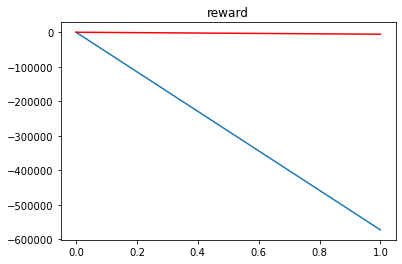



Episode: 1000, reward: -246769.57222548567
mean -288768.77277688327
mean_n1 -168707.57402914803
mean_n2 -68578.7654412369
mean_n3 -51482.43330649835
reward_episode_score_n1: -125366.63871678972
reward_episode_score_n2: -96151.63722654131
reward_episode_score_n3: -25251.296282154624
reward_episode_score_T12: -1397.702734552123
reward_episode_score_T13: -9343.876400259833
reward_episode_score_T23: -5934.715094973908
solar [ 5.126608   29.20847827 47.53918018 54.45468158 54.10950268 47.07620133
 29.5894739   6.09116228]
pb [ 182.60418177  146.98989391  199.63386059  -19.5966363   -40.8297658
 -152.00968981 -200.          -85.84954739]
f_pb [ 182.60418177   97.39581823    0.          -19.5966363   -40.8297658
 -152.00968981  -67.5639081    -0.        ]
power [ 3.15595802e+02  1.68187340e+02  5.24608198e+01  2.59486821e+01
  2.84217094e-14 -1.42108547e-14  2.33406641e+01  2.90937265e+02]
f_power [3.15595802e+02 1.68187340e+02 5.24608198e+01 2.59486821e+01
 2.84217094e-14 0.00000000e+00 2.

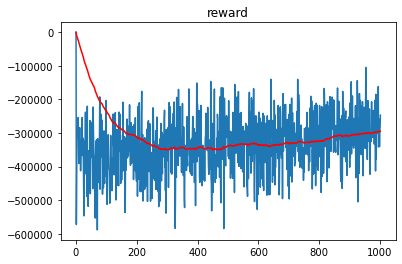



Episode: 2000, reward: -309569.8558259523
mean -204312.01775690445
mean_n1 -140900.04639087414
mean_n2 -32399.95675488092
mean_n3 -31012.014611149338
reward_episode_score_n1: -165145.75465948088
reward_episode_score_n2: -42306.39787423579
reward_episode_score_n3: -102117.70329223564
reward_episode_score_T12: -662.8646385770685
reward_episode_score_T13: -6122.8563785900915
reward_episode_score_T23: -3405.004286054669
solar [ 4.57240052 30.57684249 45.11198494 51.42528828 53.78769887 45.41038594
 30.10702228  4.16116569]
pb [  54.53228951  200.           60.52647829  200.          200.
 -200.          -19.92452145 -200.        ]
f_pb [  54.53228951  200.           25.46771049    0.            0.
 -200.          -19.92452145  -60.07547855]
power [ 1.60525241e+02  5.21047758e+02  1.10940627e+02  1.28350707e+02
  3.87574473e+02 -2.13162821e-14 -7.10542736e-15  2.84217094e-14]
f_power [1.60525241e+02 5.21047758e+02 1.10940627e+02 1.28350707e+02
 3.87574473e+02 0.00000000e+00 0.00000000e+00

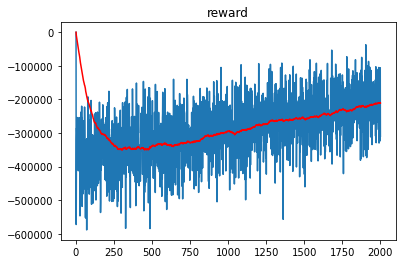



Episode: 3000, reward: -151323.66855450254
mean -152576.30627064197
mean_n1 -123477.48505819343
mean_n2 -11840.884860027689
mean_n3 -17257.93635242088
reward_episode_score_n1: -135251.1522932962
reward_episode_score_n2: 2533.3626036279375
reward_episode_score_n3: -18605.87886483429
reward_episode_score_T12: -6596.153730340902
reward_episode_score_T13: -8286.908747772373
reward_episode_score_T23: -1460.1530158648839
solar [ 4.96271732 30.91783674 48.22676872 53.55688294 53.87818508 45.60220415
 29.80304832  3.46432884]
pb [-116.21884108 -200.         -200.          200.           41.85267687
  200.         -137.26207018 -132.43100643]
f_pb [  -0.           -0.           -0.          200.           41.85267687
   38.14732313 -137.26207018 -132.43100643]
power [2.91118182e+02 2.11139810e+02 1.10355992e+02 3.36373896e+02
 1.31735511e+02 1.78704676e+02 2.13162821e-14 2.07155720e+01]
f_power [2.91118182e+02 2.11139810e+02 1.10355992e+02 3.36373896e+02
 1.31735511e+02 1.78704676e+02 2.13162

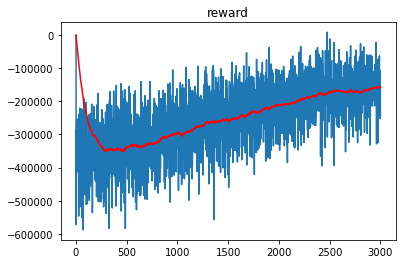



Episode: 4000, reward: -39604.49846020564
mean -95060.76249323657
mean_n1 -86555.2324084375
mean_n2 1074.0619995158418
mean_n3 -9579.592084314929
reward_episode_score_n1: -43622.553275778584
reward_episode_score_n2: 14534.400033906179
reward_episode_score_n3: -10516.34521833323
reward_episode_score_T12: -3082.018931977213
reward_episode_score_T13: -4068.1389806079496
reward_episode_score_T23: -2593.5664428241657
solar [ 3.26817013 29.3999558  45.85513195 51.95567933 55.7249351  45.98263468
 28.87167431  5.54281065]
pb [ 200.           40.13442397   60.43453813  115.98331928 -135.59525013
   79.51573133    9.39484835 -200.        ]
f_pb [ 200.           40.13442397   39.86557603    0.         -135.59525013
   79.51573133    9.39484835 -200.        ]
power [451.34153984 165.87729848 143.11912517 333.55513486 130.74960722
 550.77740957 315.94196312 143.94396952]
f_power [451.34153984 165.87729848 143.11912517 333.55513486 130.74960722
 550.77740957 315.94196312 143.94396952]
demand [ 96

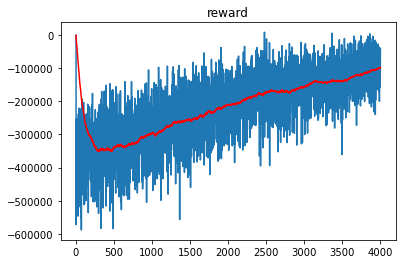

i_episode 5000
mu tensor([ 0.6274, -0.7831], grad_fn=<AddBackward0>) sigma tensor([1.3011, 0.6653], grad_fn=<AddBackward0>)
i_episode 5000
mu tensor([ 0.3478, -0.9557], grad_fn=<AddBackward0>) sigma tensor([0.3270, 0.3425], grad_fn=<AddBackward0>)
i_episode 5000
mu tensor([ 0.2968, -1.0833], grad_fn=<AddBackward0>) sigma tensor([0.2639, 0.5680], grad_fn=<AddBackward0>)
i_episode 5000
mu tensor([0.4534], grad_fn=<AddBackward0>) sigma tensor([0.9150], grad_fn=<AddBackward0>)
i_episode 5000
mu tensor([0.2263], grad_fn=<AddBackward0>) sigma tensor([0.8410], grad_fn=<AddBackward0>)
i_episode 5000
mu tensor([-1.6824], grad_fn=<AddBackward0>) sigma tensor([0.1785], grad_fn=<AddBackward0>)
statevalue -3.6622071266174316
statevalue 0.44028961658477783
statevalue 0.2866399884223938
statevalue -0.0929933488368988
statevalue 0.08714814484119415
statevalue -0.153457373380661
statevalue -3.632204055786133
statevalue 0.39514780044555664
statevalue -0.04983586072921753
statevalue 0.09971562027931213
s

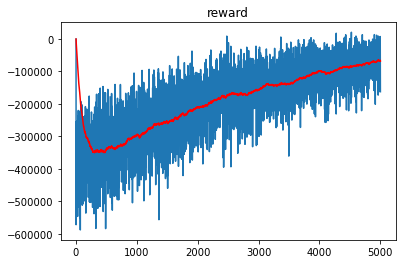



Episode: 6000, reward: 14258.085066403692
mean -34871.59583483492
mean_n1 -42126.592746043185
mean_n2 9600.010247467733
mean_n3 -2345.0133362594606
reward_episode_score_n1: 7501.033943501104
reward_episode_score_n2: 12023.998312858657
reward_episode_score_n3: -5266.9471899560685
reward_episode_score_T12: -4319.559998534101
reward_episode_score_T13: -3363.3605095843254
reward_episode_score_T23: -2176.7151291942573
solar [ 5.09375102 31.26293157 46.45732737 54.5441771  54.11635934 44.921978
 29.32434436  4.18894395]
pb [ 200.          113.96594048  -82.41754174  -60.61728597   58.09069276
 -200.          166.49259329   50.44345856]
f_pb [ 200.           80.          -82.41754174  -60.61728597   58.09069276
 -195.05586505  166.49259329   50.44345856]
power [349.42867242 162.36954655 141.56262778 259.75502338 331.79427834
 318.71647787 600.         235.40959254]
f_power [349.42867242 162.36954655 141.56262778 259.75502338 331.79427834
 318.71647787 600.         235.40959254]
demand [  0.

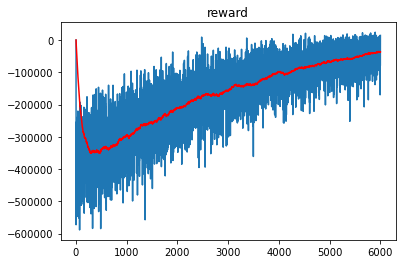

printing new best model 39819.13386636954


Episode: 6265, reward: 39819.13386636954
mean -28307.416266030526
mean_n1 -38171.01867098488
mean_n2 9287.161894084513
mean_n3 576.4405108698427
reward_episode_score_n1: 12771.968950808225
reward_episode_score_n2: 15245.848449590545
reward_episode_score_n3: 11801.316465970773
reward_episode_score_T12: -992.0867790590689
reward_episode_score_T13: -1500.3435043103973
reward_episode_score_T23: -311.11068140288955
solar [ 3.38026056 28.70175999 45.16495064 55.37235503 55.07205727 45.09556729
 31.1917504   4.22509972]
pb [ 83.46535563 116.97345972  87.04363108 -17.82247722  72.89484739
  -6.4735055  -87.38953471 -75.15206337]
f_pb [ 83.46535563 116.97345972  79.56118464 -17.82247722  17.82247722
  -6.4735055  -87.38953471 -75.15206337]
power [318.31613264 274.97509885 484.396234   154.78872593 461.01672945
 573.32197588 454.65904422 225.10815274]
f_power [318.31613264 274.97509885 484.396234   154.78872593 461.01672945
 573.32197588 454.65904422 2



Episode: 7000, reward: -18170.809940584746
mean -11793.489574605008
mean_n1 -25535.386377682506
mean_n2 10292.066443944772
mean_n3 3449.8303591327253
reward_episode_score_n1: -16648.973872650982
reward_episode_score_n2: 6987.4716799748185
reward_episode_score_n3: -8509.307747908577
reward_episode_score_T12: -3994.0306825719263
reward_episode_score_T13: -3759.708018836757
reward_episode_score_T23: -150.6881842366755
solar [ 4.74331739 28.46372816 45.80721406 52.28601265 53.96580418 47.69879724
 29.87289231  5.71770163]
pb [ 200.          -14.78997469  200.            2.96779275 -127.67385244
 -149.63738918  165.3418541  -193.08052063]
f_pb [ 200.          -14.78997469   94.78997469    0.         -127.67385244
 -149.63738918  165.3418541  -168.03061247]
power [3.36015766e+02 1.77080424e+02 3.78608363e+02 1.39694781e+02
 0.00000000e+00 2.13162821e-14 6.00000000e+02 3.41270497e+02]
f_power [3.36015766e+02 1.77080424e+02 3.78608363e+02 1.39694781e+02
 0.00000000e+00 2.13162821e-14 6.00000

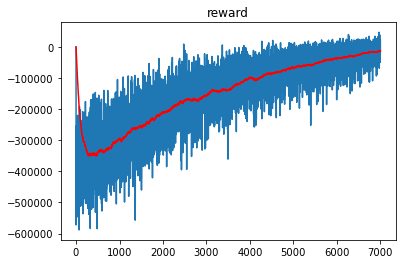

printing new best model 49238.66200127789


Episode: 7326, reward: 49238.66200127789
mean -5938.262676710994
mean_n1 -20213.360326553375
mean_n2 10281.300095607225
mean_n3 3993.7975542351587
reward_episode_score_n1: 15786.537518510735
reward_episode_score_n2: 7449.885706079195
reward_episode_score_n3: 26002.238776687966
reward_episode_score_T12: -1072.239150308617
reward_episode_score_T13: -938.4221122662901
reward_episode_score_T23: -205.98406821447472
solar [ 4.92407728 29.19665227 45.62778222 52.33351212 56.33215752 44.2840379
 30.27478484  6.37127347]
pb [ 200.          -68.64609718  154.03140783 -106.48435354   62.61381507
   28.67420912 -102.90757418 -200.        ]
f_pb [ 200.          -68.64609718  148.64609718 -106.48435354   62.61381507
   28.67420912 -102.90757418 -161.89609647]
power [542.90287893 105.62833776 449.01568947 248.44481725 456.28165755
 415.71195756 543.01955374 329.47304778]
f_power [542.90287893 105.62833776 449.01568947 248.44481725 456.28165755
 415.71195756



Episode: 8000, reward: -6716.853833207529
mean 7041.583256539789
mean_n1 -7017.368219168276
mean_n2 12064.797018032677
mean_n3 1994.1544576753897
reward_episode_score_n1: -28021.46018091289
reward_episode_score_n2: 6990.806583679336
reward_episode_score_n3: 14313.79976402603
reward_episode_score_T12: -1361.6553979466635
reward_episode_score_T13: -338.1514361439781
reward_episode_score_T23: -1154.3984697863812
solar [ 3.90123619 29.91604272 45.17949736 55.3408929  54.89898231 45.57577174
 30.08151596  4.0298599 ]
pb [ 200.           88.30655217   54.92088795 -200.          200.
 -128.61851454 -200.           80.59710264]
f_pb [ 200.           80.            0.         -200.          200.
 -128.61851454 -151.38148546   80.59710264]
power [ 5.58344292e+02  8.22631430e+01  4.04820503e+02 -1.42108547e-14
  6.00000000e+02  4.68146448e+02  4.51837502e+02  6.00000000e+02]
f_power [558.34429221  82.26314303 404.82050264   0.         600.
 468.14644832 451.83750155 600.        ]
demand [200.  

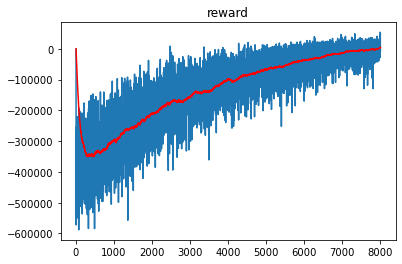



Episode: 9000, reward: 24401.914032674464
mean 15711.019144192354
mean_n1 1194.9730604045455
mean_n2 11539.674756700786
mean_n3 2976.371327087028
reward_episode_score_n1: 17287.993682631335
reward_episode_score_n2: 7760.256228849979
reward_episode_score_n3: -646.3358788068526
reward_episode_score_T12: -1886.0451371009024
reward_episode_score_T13: -2848.6216494063005
reward_episode_score_T23: -440.0333558964162
solar [ 5.23379489 30.57169596 45.63728329 52.91174054 54.41542053 46.34651268
 29.60542167  5.81882177]
pb [ 200.          -73.33534956  114.9823904   -15.14563262 -130.08675575
  200.          -66.33825302  -64.28342462]
f_pb [ 200.          -73.33534956  114.9823904   -15.14563262 -130.08675575
  183.58534753  -66.33825302  -64.28342462]
power [478.67840186 115.01632011 334.49568246 244.7540015  271.99420249
 600.         424.42652856  10.79085739]
f_power [478.67840186 115.01632011 334.49568246 244.7540015  271.99420249
 600.         424.42652856  10.79085739]
demand [200. 

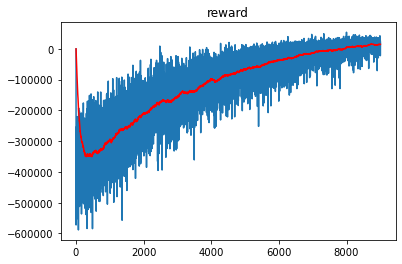

i_episode 10000
mu tensor([ 1.0673, -1.3331], grad_fn=<AddBackward0>) sigma tensor([0.6106, 0.4059], grad_fn=<AddBackward0>)
i_episode 10000
mu tensor([ 0.0736, -1.1592], grad_fn=<AddBackward0>) sigma tensor([0.1583, 0.2070], grad_fn=<AddBackward0>)
i_episode 10000
mu tensor([ 0.1940, -0.9014], grad_fn=<AddBackward0>) sigma tensor([0.1152, 0.4497], grad_fn=<AddBackward0>)
i_episode 10000
mu tensor([0.4553], grad_fn=<AddBackward0>) sigma tensor([0.9209], grad_fn=<AddBackward0>)
i_episode 10000
mu tensor([0.2259], grad_fn=<AddBackward0>) sigma tensor([0.8471], grad_fn=<AddBackward0>)
i_episode 10000
mu tensor([-1.6897], grad_fn=<AddBackward0>) sigma tensor([0.1782], grad_fn=<AddBackward0>)
statevalue 1.168047308921814
statevalue 1.1525627374649048
statevalue 0.16695544123649597
statevalue -0.25161296129226685
statevalue -0.23138658702373505
statevalue -0.30389338731765747
statevalue 0.6507410407066345
statevalue 1.0494171380996704
statevalue 0.007008075714111328
statevalue -0.13449522852

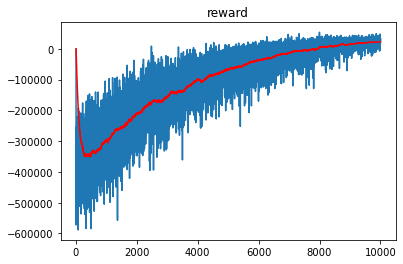



Episode: 11000, reward: 34050.38915650219
mean 27707.218887517916
mean_n1 9396.9816093
mean_n2 15404.450764652342
mean_n3 2905.78651356557
reward_episode_score_n1: 12759.108447690336
reward_episode_score_n2: 11855.592102503539
reward_episode_score_n3: 9435.688606308318
reward_episode_score_T12: -903.873124287305
reward_episode_score_T13: -931.5685391743492
reward_episode_score_T23: -24.982575976680355
solar [ 4.10920901 29.37381743 46.41252814 55.00439454 53.0650038  46.31241391
 31.5069776   7.15942199]
pb [167.2752738  156.74967766 -36.7357105  -25.21810532   8.94822031
  51.65675879  30.56914806  46.29195631]
f_pb [167.2752738  112.7247262  -36.7357105  -25.21810532   8.94822031
  51.65675879   1.34883672   0.        ]
power [417.27687644 183.35090877 117.20175685 291.71373796 495.79045142
 543.39675328 557.67140128 590.37088042]
f_power [417.27687644 183.35090877 117.20175685 291.71373796 495.79045142
 543.39675328 557.67140128 590.37088042]
demand [200.           0.         102.

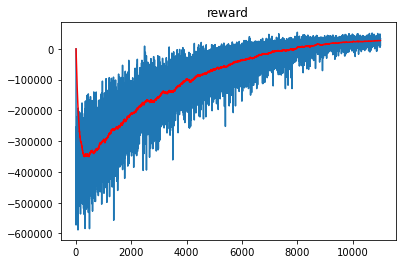



Episode: 12000, reward: 22952.722579135676
mean 29666.220868036482
mean_n1 10758.977641194318
mean_n2 17292.515286159665
mean_n3 1614.7279406824975
reward_episode_score_n1: 7262.892691761797
reward_episode_score_n2: 25121.762506129766
reward_episode_score_n3: -9431.93261875589
reward_episode_score_T12: -529.8355878214604
reward_episode_score_T13: -1002.9234150660948
reward_episode_score_T23: -1695.7589587905704
solar [ 5.06601718 29.29470512 45.00363023 53.72929174 54.47730666 47.1163151
 27.48715369  4.67650739]
pb [200.         117.61573553 -14.49206918  55.82728982  -1.40949339
  57.30019808  -2.47172639  27.78382003]
f_pb [200.          80.         -14.49206918  14.49206918  -1.40949339
   1.40949339  -2.47172639   2.47172639]
power [514.23119518 293.58880607 275.41043907 413.93012952 333.66850817
 463.38709172 535.59823619 497.795219  ]
f_power [514.23119518 293.58880607 275.41043907 413.93012952 333.66850817
 463.38709172 535.59823619 497.795219  ]
demand [200.         180.    

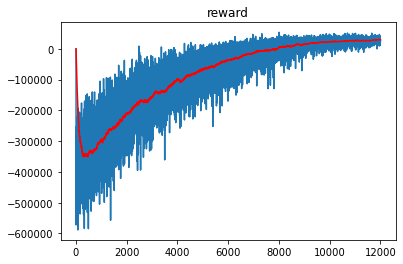



Episode: 13000, reward: 39637.05424494872
mean 31101.54998106766
mean_n1 13170.598008534633
mean_n2 17890.223380931904
mean_n3 40.72859160112607
reward_episode_score_n1: 11290.024146794422
reward_episode_score_n2: 18926.052968158732
reward_episode_score_n3: 9420.977129995566
reward_episode_score_T12: -158.17582924503466
reward_episode_score_T13: -516.6764872776956
reward_episode_score_T23: -511.6085407805988
solar [ 5.77017286 28.55114522 44.66267175 53.61194772 51.85616656 47.08669193
 30.38062092  3.16999325]
pb [110.33869982 134.55221653   1.36999488  28.88110578   7.45450407
  49.33727682  -7.84404799  58.86828303]
f_pb [110.33869982 134.55221653   1.36999488  28.88110578   4.85798299
   0.          -7.84404799   7.84404799]
power [458.33776675 283.5332751  224.74637829 428.68513751 465.85610049
 586.66371695 561.77533108 504.67405474]
f_power [458.33776675 283.5332751  224.74637829 428.68513751 465.85610049
 586.66371695 561.77533108 504.67405474]
demand [200.          82.550816

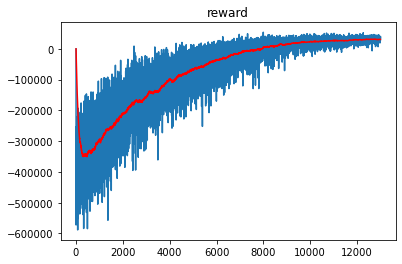



Episode: 14000, reward: 39895.66367685162
mean 33899.315036506116
mean_n1 14512.766794961712
mean_n2 19819.829501586057
mean_n3 -433.28126004164596
reward_episode_score_n1: 11355.05620354168
reward_episode_score_n2: 22512.60687417272
reward_episode_score_n3: 6028.000599137211
reward_episode_score_T12: -64.04339630805555
reward_episode_score_T13: -512.7154149987266
reward_episode_score_T23: -683.2580690067057
solar [ 4.26955113 29.91966575 43.72284464 52.24223639 53.86798855 44.80850417
 30.92253436  5.15812037]
pb [200.          70.24807334  -5.66876233  -5.04694879  31.19679987
  23.43623936 -22.99420834  78.98019552]
f_pb [200.          70.24807334  -5.66876233  -5.04694879  20.46763778
   0.         -22.99420834  22.99420834]
power [556.60275257 403.47640127 319.04938468 264.66769521 492.5938398
 545.12567576 552.09271308 446.81311252]
f_power [556.60275257 403.47640127 319.04938468 264.66769521 492.5938398
 545.12567576 552.09271308 446.81311252]
demand [200.         180.        

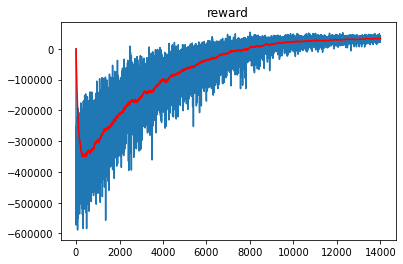

i_episode 15000
mu tensor([ 1.0301, -1.3114], grad_fn=<AddBackward0>) sigma tensor([0.4201, 0.3060], grad_fn=<AddBackward0>)
i_episode 15000
mu tensor([ 0.0482, -1.1616], grad_fn=<AddBackward0>) sigma tensor([0.0831, 0.1288], grad_fn=<AddBackward0>)
i_episode 15000
mu tensor([ 0.1807, -0.7000], grad_fn=<AddBackward0>) sigma tensor([0.0817, 0.3515], grad_fn=<AddBackward0>)
i_episode 15000
mu tensor([0.4563], grad_fn=<AddBackward0>) sigma tensor([0.9231], grad_fn=<AddBackward0>)
i_episode 15000
mu tensor([0.2243], grad_fn=<AddBackward0>) sigma tensor([0.8498], grad_fn=<AddBackward0>)
i_episode 15000
mu tensor([-1.6926], grad_fn=<AddBackward0>) sigma tensor([0.1776], grad_fn=<AddBackward0>)
statevalue 2.080137252807617
statevalue 1.4340702295303345
statevalue 0.16450096666812897
statevalue -0.24776509404182434
statevalue -0.36748838424682617
statevalue -0.3706352710723877
statevalue 1.5099186897277832
statevalue 1.3205361366271973
statevalue -0.024297699332237244
statevalue -0.23005545139

statevalue -0.2454441785812378
statevalue -0.27524715662002563
statevalue -0.06721948832273483


Episode: 15000, reward: 36119.742518043495
mean 35425.011096056885
mean_n1 16739.16897365312
mean_n2 18639.958480608042
mean_n3 45.883641795723605
reward_episode_score_n1: 12371.035822220587
reward_episode_score_n2: 18375.761586662855
reward_episode_score_n3: 5372.945109160046
reward_episode_score_T12: -252.13262290901912
reward_episode_score_T13: -516.124372995117
reward_episode_score_T23: -660.5912204629434
solar [ 7.78530612 27.82909561 45.89010658 53.63605284 53.83561974 47.2134147
 28.12422426  5.34076032]
pb [191.4039731  135.0428462  -12.44506463   7.50535727  39.03875947
  12.25009933  13.86814117  -6.66197836]
f_pb [191.4039731   88.5960269  -12.44506463   7.50535727   4.93970737
   0.           0.          -6.66197836]
power [542.15822295 269.94804662 322.65750958 443.67355442 377.45015124
 599.91769155 560.99679483 501.30067679]
f_power [542.15822295 269.94804662 322.65750958 443

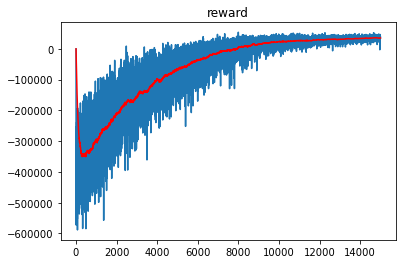



Episode: 16000, reward: 40663.37525975504
mean 38191.32786571296
mean_n1 17498.036005199934
mean_n2 19549.715913076987
mean_n3 1143.5759474360455
reward_episode_score_n1: 13199.770334565372
reward_episode_score_n2: 26371.57758053063
reward_episode_score_n3: 1092.0273446590381
reward_episode_score_T12: -556.7696804569952
reward_episode_score_T13: -495.26947453655754
reward_episode_score_T23: -881.0971778350079
solar [ 5.96853974 29.55821388 47.10149617 53.34682818 55.71055329 46.41324796
 30.21412038  5.05216085]
pb [ 70.40625811 200.          11.65791675  13.90329152  25.06677806
  33.20097923 -22.5627929   70.57535648]
f_pb [ 70.40625811 200.           9.59374189   0.           0.
   0.         -22.5627929   22.5627929 ]
power [422.63516752 187.90453739 412.49224573 312.54958157 334.20692169
 577.31846802 566.37697972 534.59209315]
f_power [422.63516752 187.90453739 412.49224573 312.54958157 334.20692169
 577.31846802 566.37697972 534.59209315]
demand [200.           0.         250.

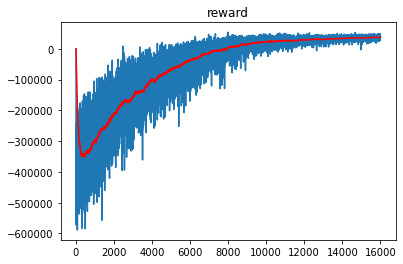

printing new best model 54372.2502907123


Episode: 16852, reward: 54372.2502907123
mean 39547.28126693206
mean_n1 18679.78652417656
mean_n2 19169.65110845983
mean_n3 1697.843634295663
reward_episode_score_n1: 7826.869595228939
reward_episode_score_n2: 27073.995802803493
reward_episode_score_n3: 19471.384892679867
reward_episode_score_T12: -76.65578707680686
reward_episode_score_T13: -1628.7007493560477
reward_episode_score_T23: -1681.0033343521923
solar [ 4.36747219 30.21457684 46.19119918 54.12743315 54.56455321 44.38807516
 30.07692356  4.66088492]
pb [ 20.54187059 183.17527771  77.53016949  24.80542064  12.20122427
  -9.37716067   9.06233788 -17.22082198]
f_pb [ 20.54187059 183.17527771  76.2828517    0.           0.
  -9.37716067   9.06233788 -17.22082198]
power [402.78946612 492.82106    413.77190823 426.65561512 488.14840346
 545.88341975 600.         574.39343792]
f_power [402.78946612 492.82106    413.77190823 426.65561512 488.14840346
 545.88341975 600.         574.39343792]


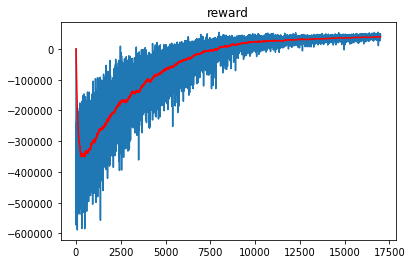

printing new best model 54669.363563468396


Episode: 17673, reward: 54669.363563468396
mean 41079.06234319286
mean_n1 18486.96923788358
mean_n2 20953.55127540068
mean_n3 1638.5418299086023
reward_episode_score_n1: 14916.45064987354
reward_episode_score_n2: 25093.375730085507
reward_episode_score_n3: 14659.537183509343
reward_episode_score_T12: -0.6294641964322696
reward_episode_score_T13: -1478.5067691712375
reward_episode_score_T23: -1480.9440821711457
solar [ 5.91704956 29.15594075 47.47679928 53.66318532 55.75120521 45.46846777
 30.71572901  4.35739266]
pb [200.          85.13763547 -35.87043583  29.31699753  -0.28609112
  10.38175002   1.5086174   -9.95701104]
f_pb [200.          80.         -35.87043583  29.31699753  -0.28609112
   6.83952942   0.          -9.95701104]
power [517.89964178 330.84405925 332.10073611 365.84224097 445.22405865
 600.         596.60032271 560.84568841]
f_power [517.89964178 330.84405925 332.10073611 365.84224097 445.22405865
 600.         596.60032271 

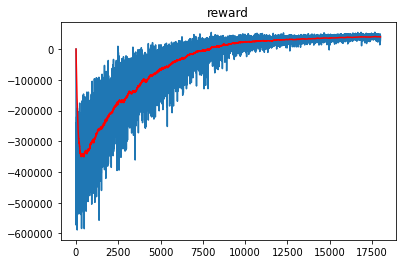



Episode: 19000, reward: 38290.648812980595
mean 40243.42914137537
mean_n1 19399.827980635535
mean_n2 20493.47449450056
mean_n3 350.1266662392761
reward_episode_score_n1: 18799.53038412472
reward_episode_score_n2: 20411.18178499279
reward_episode_score_n3: -920.0633561369132
reward_episode_score_T12: -53.39797262090481
reward_episode_score_T13: -1339.3228149052884
reward_episode_score_T23: -1269.1656033009317
solar [ 5.9905513  28.7873307  44.70439845 53.4143965  54.45803776 46.1769144
 27.61568581  5.15919067]
pb [ 2.00000000e+02  5.86997986e+01 -1.99911445e+00  3.55289698e+01
 -6.59909993e+00  1.70900635e+00 -5.06922603e-02  1.63264394e+01]
f_pb [ 2.00000000e+02  5.86997986e+01 -1.99911445e+00  2.32993159e+01
 -6.59909993e+00  1.70900635e+00 -5.06922603e-02  4.94078584e+00]
power [483.18758171 242.17290371 271.84188223 424.06994551 358.78810063
 462.82558004 600.         462.60818392]
f_power [483.18758171 242.17290371 271.84188223 424.06994551 358.78810063
 462.82558004 600.       

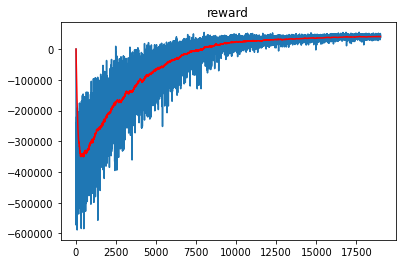

i_episode 20000
mu tensor([ 0.8924, -1.3176], grad_fn=<AddBackward0>) sigma tensor([0.3826, 0.2723], grad_fn=<AddBackward0>)
i_episode 20000
mu tensor([ 0.0419, -1.1435], grad_fn=<AddBackward0>) sigma tensor([0.0596, 0.1006], grad_fn=<AddBackward0>)
i_episode 20000
mu tensor([ 0.1928, -0.5360], grad_fn=<AddBackward0>) sigma tensor([0.0646, 0.2400], grad_fn=<AddBackward0>)
i_episode 20000
mu tensor([0.4545], grad_fn=<AddBackward0>) sigma tensor([0.9228], grad_fn=<AddBackward0>)
i_episode 20000
mu tensor([0.2253], grad_fn=<AddBackward0>) sigma tensor([0.8526], grad_fn=<AddBackward0>)
i_episode 20000
mu tensor([-1.6905], grad_fn=<AddBackward0>) sigma tensor([0.1772], grad_fn=<AddBackward0>)
statevalue 1.5479875802993774
statevalue 1.5525916814804077
statevalue 0.22202444076538086
statevalue -0.1455320119857788
statevalue -0.4319200813770294
statevalue -0.4241679012775421
statevalue 0.9694232940673828
statevalue 1.4497348070144653
statevalue 0.08534593135118484
statevalue -0.15191134810447

pow_pen [-0. -0. -0. -0. -0. -0. -0. -0.]
SoC [ 48.39316308  59.34748203  73.56576174 102.52371281  34.17382091
  44.42814142   0.           5.66727594]
f_tvol [  0.         100.          21.31670713  78.97737622   2.47142017
 100.          38.58748302 100.        ]
reward [ -0.         -79.47396437  -0.          -0.          -0.
  -0.          -0.          -0.        ]
f_tvol [100.           0.           0.          29.91504818  48.90090227
  34.56949592  64.7321403   87.45483756]
reward [-356.67196972  -66.15278139 -139.07731228  -37.14480727 -235.5880697
  -24.65277792   -0.          -31.94785991]
f_tvol [0. 0. 0. 0. 0. 0. 0. 0.]
reward [-356.67196972 -290.64293506 -139.07731228  -37.14480727 -235.5880697
  -24.65277792   -0.          -31.94785991]


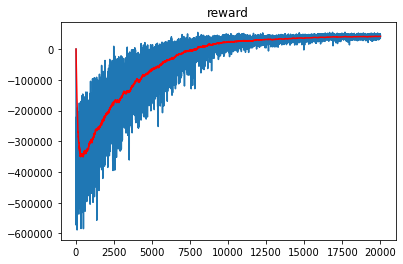

printing new best model 55094.00989932322


Episode: 20316, reward: 55094.00989932322
mean 40929.72803457976
mean_n1 19616.043860040725
mean_n2 20150.772808886402
mean_n3 1162.9113656526358
reward_episode_score_n1: 12307.206385786238
reward_episode_score_n2: 29975.156732395702
reward_episode_score_n3: 12811.646781141275
reward_episode_score_T12: -6.88085160931227
reward_episode_score_T13: -1332.641347802702
reward_episode_score_T23: -1343.7924861406432
solar [ 5.5858213  29.59218355 45.35967273 54.73713299 54.46785588 46.89161762
 30.60856703  4.94196982]
pb [196.80651426  66.07067585  19.11278665  -2.69412436  18.34447384
 -14.69739676  -5.59078082  24.34255779]
f_pb [196.80651426  66.07067585  17.12280989  -2.69412436   2.69412436
 -14.69739676  -5.59078082  20.28817758]
power [492.03247097 314.29729609 421.76313716 394.20298728 484.26093
 583.93716529 600.         537.28720798]
f_power [492.03247097 314.29729609 421.76313716 394.20298728 484.26093
 583.93716529 600.         537.2872

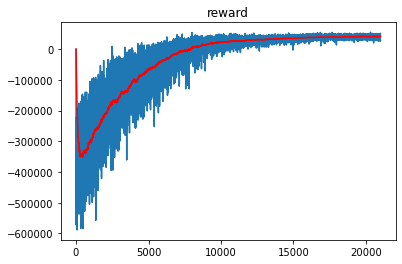



Episode: 22000, reward: 39980.30643589428
mean 42390.59767027655
mean_n1 20336.260297319863
mean_n2 20669.454696166533
mean_n3 1384.8826767901483
reward_episode_score_n1: 18902.16949896628
reward_episode_score_n2: 16247.702546730694
reward_episode_score_n3: 4830.434390197311
reward_episode_score_T12: -53.81959985456935
reward_episode_score_T13: -697.4270517707187
reward_episode_score_T23: -887.0369244831511
solar [ 5.57330975 30.14203993 44.28987393 53.89804009 54.28635809 46.35155294
 29.48215645  6.31695082]
pb [200.          80.6406796  -11.45806313   3.32081206   6.96597025
   2.28223577  -6.37126416  -2.7626887 ]
f_pb [200.          80.         -11.45806313   3.32081206   6.96597025
   1.17128082  -6.37126416  -2.7626887 ]
power [457.24249652 329.85796007 367.15399137 340.50646845 444.65081137
 577.3418108  527.43862677 505.06344597]
f_power [457.24249652 329.85796007 367.15399137 340.50646845 444.65081137
 577.3418108  527.43862677 505.06344597]
demand [162.81580627 180.       

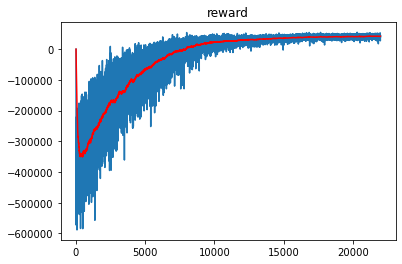

printing new best model 55745.22845774919


Episode: 22256, reward: 55745.22845774919
mean 42580.508400498795
mean_n1 20424.739997899953
mean_n2 20581.253406730564
mean_n3 1574.5149958682784
reward_episode_score_n1: 13156.957802419442
reward_episode_score_n2: 29721.474679055304
reward_episode_score_n3: 12866.795976274438
reward_episode_score_T12: -40.572298206884255
reward_episode_score_T13: -1185.7555010925582
reward_episode_score_T23: -936.595557742836
solar [ 6.91776054 28.90013628 46.13650331 55.11014792 53.59544119 46.12094635
 29.19992067  5.18512331]
pb [169.75271702  82.18238354  11.47437841  16.28428102   3.22502144
 -16.78338349 -49.62938726 -31.98207617]
f_pb [169.75271702  82.18238354  11.47437841  16.28428102   0.30624002
 -16.78338349 -49.62938726 -31.98207617]
power [555.75348659 349.3470513  272.21187464 461.17413309 471.70519748
 515.57719236 600.         562.83280052]
f_power [555.75348659 349.3470513  272.21187464 461.17413309 471.70519748
 515.57719236 600.         

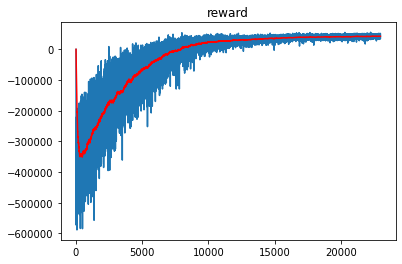

printing new best model 59378.51542176677


Episode: 23257, reward: 59378.51542176677
mean 43348.56976108653
mean_n1 20921.279780186786
mean_n2 20646.896786254765
mean_n3 1780.3931946449845
reward_episode_score_n1: 12271.432301161718
reward_episode_score_n2: 27979.83548893066
reward_episode_score_n3: 19127.247631674392
reward_episode_score_T12: -509.1185663132289
reward_episode_score_T13: -903.598520487265
reward_episode_score_T23: -1696.0603160940084
solar [ 4.53164186 28.32048476 46.75165836 55.1638416  53.24447157 46.09017479
 30.07804845  4.27336108]
pb [155.17103672 143.63013506 -11.08919978 -17.89841503   6.68171868
  -2.95783989 -35.39062738  23.70742857]
f_pb [155.17103672 124.82896328 -11.08919978 -17.89841503   6.68171868
  -2.95783989 -35.39062738  23.70742857]
power [490.94942604 196.50847852 392.15914186 414.92857272 450.48438532
 520.11888702 600.         600.        ]
f_power [490.94942604 196.50847852 392.15914186 414.92857272 450.48438532
 520.11888702 600.         600

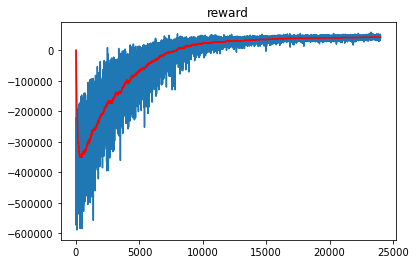

i_episode 25000
mu tensor([ 0.8300, -1.3107], grad_fn=<AddBackward0>) sigma tensor([0.3515, 0.2553], grad_fn=<AddBackward0>)
i_episode 25000
mu tensor([ 0.0345, -1.0839], grad_fn=<AddBackward0>) sigma tensor([0.0450, 0.0889], grad_fn=<AddBackward0>)
i_episode 25000
mu tensor([ 0.2790, -0.4152], grad_fn=<AddBackward0>) sigma tensor([0.0499, 0.1650], grad_fn=<AddBackward0>)
i_episode 25000
mu tensor([0.4540], grad_fn=<AddBackward0>) sigma tensor([0.9220], grad_fn=<AddBackward0>)
i_episode 25000
mu tensor([0.2260], grad_fn=<AddBackward0>) sigma tensor([0.8562], grad_fn=<AddBackward0>)
i_episode 25000
mu tensor([-1.6966], grad_fn=<AddBackward0>) sigma tensor([0.1759], grad_fn=<AddBackward0>)
statevalue 1.594495415687561
statevalue 1.5162519216537476
statevalue 0.23078520596027374
statevalue -0.06410770118236542
statevalue -0.5246303677558899
statevalue -0.5345543622970581
statevalue 1.101572871208191
statevalue 1.4193660020828247
statevalue 0.09591300785541534
statevalue -0.070073753595352

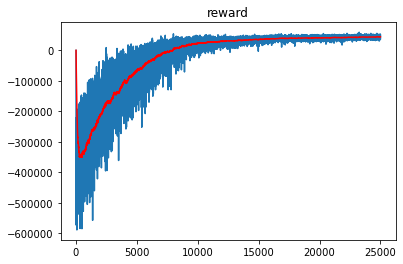



Episode: 26000, reward: 42308.52286147452
mean 45221.933402759
mean_n1 21644.17610628576
mean_n2 20085.06327279714
mean_n3 3492.6940236761066
reward_episode_score_n1: 24283.09153904706
reward_episode_score_n2: 17328.311009584333
reward_episode_score_n3: 697.1203128431212
reward_episode_score_T12: -6.492448675570571
reward_episode_score_T13: -1457.0126315834705
reward_episode_score_T23: -1388.504623486736
solar [ 5.36903442 28.4030151  45.50643066 52.67289799 53.23519638 46.76204892
 28.70179008  5.3632728 ]
pb [113.03756237 101.70927048  43.01091433  17.81437993   0.59528239
 -26.82998776 -29.51977849   9.35252905]
f_pb [113.03756237 101.70927048  43.01091433  17.81437993   0.59528239
 -26.82998776 -29.51977849   9.35252905]
power [395.37900984 407.33267728 272.85031875 420.34282315 328.73128758
 425.87145893 600.         457.75993548]
f_power [395.37900984 407.33267728 272.85031875 420.34282315 328.73128758
 425.87145893 600.         457.75993548]
demand [200.         180.         2

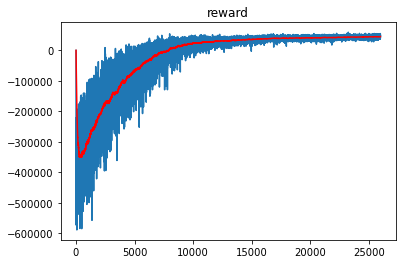



Episode: 27000, reward: 43983.540393928684
mean 45810.131056222264
mean_n1 21659.105103948925
mean_n2 20312.152431888317
mean_n3 3838.8735203850138
reward_episode_score_n1: 22087.648417878816
reward_episode_score_n2: 18531.23461790075
reward_episode_score_n3: 3364.657358149122
reward_episode_score_T12: -235.09095109468933
reward_episode_score_T13: -523.161930396832
reward_episode_score_T23: -945.1080687545045
solar [ 5.30573863 29.16198825 46.14350099 54.84726972 54.7376761  45.29981634
 30.74829233  5.43332153]
pb [139.61319923 157.49698877  -3.92920487 -11.15828827   2.43381299
 -22.20138907 -47.33327627   3.44099216]
f_pb [139.61319923 140.38680077  -3.92920487 -11.15828827   2.43381299
 -22.20138907 -47.33327627   3.44099216]
power [350.74532789 294.49968542 341.76877279 246.73062839 369.4005931
 432.16318616 600.         538.87454852]
f_power [350.74532789 294.49968542 341.76877279 246.73062839 369.4005931
 432.16318616 600.         538.87454852]
demand [200.          60.1129758

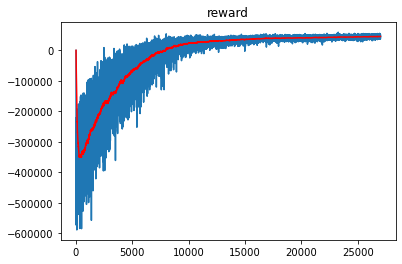



Episode: 28000, reward: 46682.75332071872
mean 45948.146233660525
mean_n1 22571.998291091524
mean_n2 20435.53087776941
mean_n3 2940.6170647995837
reward_episode_score_n1: 17153.755800315623
reward_episode_score_n2: 19404.816374556554
reward_episode_score_n3: 10124.181145846542
reward_episode_score_T12: -10.570309650102349
reward_episode_score_T13: -2482.8757071561117
reward_episode_score_T23: -2483.2183542523367
solar [ 5.14905343 29.48005842 47.23060849 54.90523598 54.43881513 46.67919301
 29.49366068  5.69944375]
pb [171.18523121 170.87132931   3.19550373  -1.05645638  -6.36576787
 -32.44351745 -68.62104535  45.99996805]
f_pb [171.18523121 108.81476879   0.          -1.05645638  -6.36576787
 -32.44351745 -68.62104535  45.99996805]
power [542.89377144 334.7462268  260.44167009 444.03830764 320.05908354
 507.79231317 503.05793786 505.23551858]
f_power [542.89377144 334.7462268  260.44167009 444.03830764 320.05908354
 507.79231317 503.05793786 505.23551858]
demand [200.         180.  

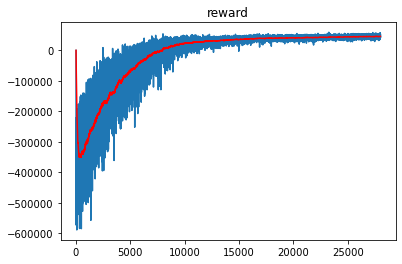

printing new best model 59533.3022422252


Episode: 28476, reward: 59533.3022422252
mean 46792.778503416994
mean_n1 22717.097422330822
mean_n2 20655.3070569303
mean_n3 3420.3740241558703
reward_episode_score_n1: 19037.245181097693
reward_episode_score_n2: 23426.036364385058
reward_episode_score_n3: 17070.020696742453
reward_episode_score_T12: -13.051207866393346
reward_episode_score_T13: -1671.495500156685
reward_episode_score_T23: -1574.437567102803
solar [ 6.81511199 30.64461906 47.55344939 54.3880234  54.30486948 45.35873239
 29.86801424  5.43095639]
pb [200.          30.57109416  53.50335836   6.36049211  -7.65774995
 -34.47034955 -63.10315132  -8.58389139]
f_pb [200.          30.57109416  49.42890584   0.          -7.65774995
 -34.47034955 -63.10315132  -8.58389139]
power [511.10338682 205.23051392 410.72798971 363.23933802 364.14657532
 536.35378922 600.         543.5519127 ]
f_power [511.10338682 205.23051392 410.72798971 363.23933802 364.14657532
 536.35378922 600.         543.

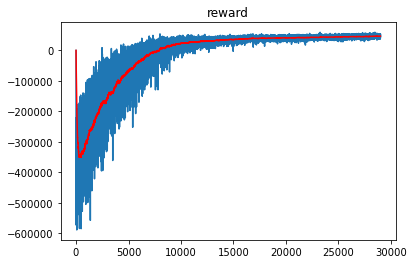

i_episode 30000
mu tensor([ 0.7324, -1.3121], grad_fn=<AddBackward0>) sigma tensor([0.3186, 0.2366], grad_fn=<AddBackward0>)
i_episode 30000
mu tensor([ 0.0238, -1.0627], grad_fn=<AddBackward0>) sigma tensor([0.0389, 0.0807], grad_fn=<AddBackward0>)
i_episode 30000
mu tensor([ 0.3715, -0.2859], grad_fn=<AddBackward0>) sigma tensor([0.0377, 0.1208], grad_fn=<AddBackward0>)
i_episode 30000
mu tensor([0.4532], grad_fn=<AddBackward0>) sigma tensor([0.9219], grad_fn=<AddBackward0>)
i_episode 30000
mu tensor([0.2273], grad_fn=<AddBackward0>) sigma tensor([0.8603], grad_fn=<AddBackward0>)
i_episode 30000
mu tensor([-1.7083], grad_fn=<AddBackward0>) sigma tensor([0.1742], grad_fn=<AddBackward0>)
statevalue 1.7360994815826416
statevalue 1.4885892868041992
statevalue 0.3623138666152954
statevalue -0.020437657833099365
statevalue -0.692343533039093
statevalue -0.737280011177063
statevalue 1.2314302921295166
statevalue 1.4084957838058472
statevalue 0.24188503623008728
statevalue -0.031760826706886

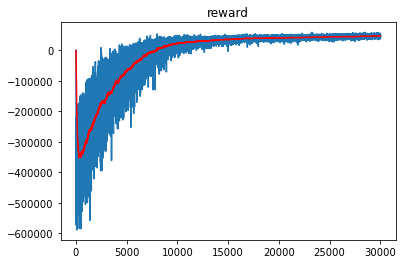

printing new best model 60179.02412882319


Episode: 30131, reward: 60179.02412882319
mean 48468.575741262
mean_n1 22946.459414502617
mean_n2 20969.95667118697
mean_n3 4552.1596555723945
reward_episode_score_n1: 17855.426429695188
reward_episode_score_n2: 28801.087668557797
reward_episode_score_n3: 13522.510030570213
reward_episode_score_T12: -3.147271131664573
reward_episode_score_T13: -2219.626456576873
reward_episode_score_T23: -2330.3213394105837
solar [ 4.88277648 30.54436172 45.92202733 53.05188178 53.16222516 46.16799343
 27.99706435  3.71536698]
pb [100.7029891  130.46405315  36.10615134  15.83258808  -5.62279895
 -36.16268039 -67.54640937 -27.72975266]
f_pb [100.7029891  130.46405315  36.10615134  12.7268064   -5.62279895
 -36.16268039 -67.54640937 -27.72975266]
power [395.82021262 347.89320682 361.0768201  366.40359016 461.59406322
 567.66932618 564.01044304 533.51650153]
f_power [395.82021262 347.89320682 361.0768201  366.40359016 461.59406322
 567.66932618 564.01044304 533.

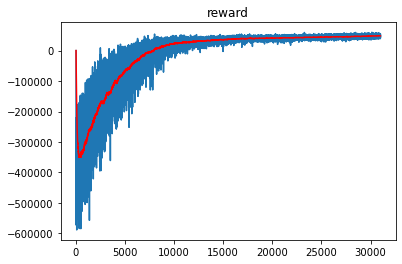

printing new best model 60845.445060265665


Episode: 31222, reward: 60845.445060265665
mean 47883.98929846933
mean_n1 24119.019587165272
mean_n2 20211.18046089667
mean_n3 3553.78925040738
reward_episode_score_n1: 19924.36079887546
reward_episode_score_n2: 26291.658911807
reward_episode_score_n3: 14629.42534958321
reward_episode_score_T12: -8.54432395101602
reward_episode_score_T13: -2287.612336325204
reward_episode_score_T23: -2296.15666027622
solar [ 4.46219374 28.45217612 46.62603983 54.23142128 54.63257801 45.31337968
 28.5223466   4.50616414]
pb [125.78215599 183.20953846   8.87728557   4.84422892 -19.85193044
 -51.5416801  -92.00563431 -43.41556132]
f_pb [125.78215599 154.21784401   0.           0.         -19.85193044
 -51.5416801  -92.00563431 -43.41556132]
power [406.33211504 404.40252158 319.62900809 403.17917951 430.24815996
 549.37051483 459.55522166 551.73287159]
f_power [406.33211504 404.40252158 319.62900809 403.17917951 430.24815996
 549.37051483 459.55522166 551.732871



Episode: 32000, reward: 52260.02782593324
mean 49233.28232694477
mean_n1 24283.425902789942
mean_n2 20648.613470754106
mean_n3 4301.242953400726
reward_episode_score_n1: 19505.434250477556
reward_episode_score_n2: 24097.447469651794
reward_episode_score_n3: 8657.14610580389
reward_episode_score_T12: -192.77666412980983
reward_episode_score_T13: -2231.1420159703093
reward_episode_score_T23: -2065.434574275678
solar [ 4.25543306 29.96283917 44.54425982 53.58037885 54.17006562 43.81983721
 30.0692025   5.21582387]
pb [165.24115801  97.28138447  11.65678203   8.45869929  -9.92556512
 -52.54645348 -95.28406262  43.63485277]
f_pb [165.24115801  97.28138447  11.65678203   5.82067549  -9.92556512
 -52.54645348 -95.28406262  43.63485277]
power [488.3625585  371.0903141  241.00226947 335.83009783 412.9422461
 505.37227473 511.65965764 472.11635687]
f_power [488.3625585  371.0903141  241.00226947 335.83009783 412.9422461
 505.37227473 511.65965764 472.11635687]
demand [200.         180.        

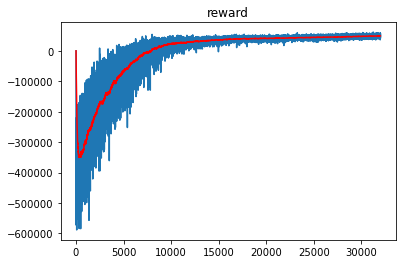



Episode: 33000, reward: 52610.44117970425
mean 50180.997217737306
mean_n1 24883.943104734084
mean_n2 20515.478990668933
mean_n3 4781.575122334295
reward_episode_score_n1: 24026.380499144267
reward_episode_score_n2: 26453.931933685526
reward_episode_score_n3: 2130.128746874454
reward_episode_score_T12: -75.25321287126549
reward_episode_score_T13: -1997.1266903013066
reward_episode_score_T23: -2438.320892187197
solar [ 5.08199067 28.78704281 44.69718863 54.39381154 54.71404076 46.30072855
 29.71012927  4.41079004]
pb [  76.39660835  115.91068506   58.16671252   23.78604412  -10.08468866
  -59.22653079 -111.85261011  -20.80716044]
f_pb [  76.39660835  115.91068506   58.16671252   23.78604412  -10.08468866
  -59.22653079 -111.85261011  -20.80716044]
power [394.84547942 311.69373958 269.07619457 388.96110355 361.67394042
 425.20026572 456.68396615 513.53806244]
f_power [394.84547942 311.69373958 269.07619457 388.96110355 361.67394042
 425.20026572 456.68396615 513.53806244]
demand [200.  

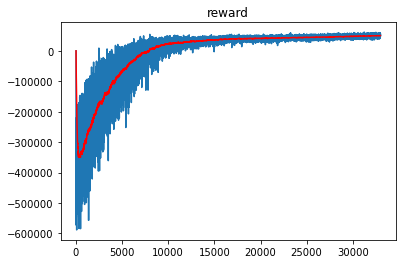

printing new best model 61997.89667051995


Episode: 33086, reward: 61997.89667051995
mean 50859.39892986008
mean_n1 24536.78141270886
mean_n2 21624.593043776964
mean_n3 4698.024473374246
reward_episode_score_n1: 17684.89474886626
reward_episode_score_n2: 24573.071566930874
reward_episode_score_n3: 19739.930354722816
reward_episode_score_T12: -3.7250273718040168
reward_episode_score_T13: -1943.4933411598945
reward_episode_score_T23: -1942.2473025832717
solar [ 5.44154252 27.12380697 45.56000314 52.67185262 53.9435531  45.94810973
 29.5863633   5.13809707]
pb [ 2.00000000e+02  7.09617734e+01  2.24012017e+01  1.46075971e+00
  1.30838156e-01 -6.78132892e+01 -1.06530917e+02 -6.46171749e+01]
f_pb [ 200.           70.9617734     9.0382266     0.            0.
  -67.81328917 -106.53091669  -64.61717486]
power [573.8727728  372.41320382 350.10507503 345.67750403 428.68971573
 483.32253848 553.46059456 515.18835638]
f_power [573.8727728  372.41320382 350.10507503 345.67750403 428.68971573
 483.



Episode: 34000, reward: 50528.34244572717
mean 50436.782638226796
mean_n1 24507.12316219298
mean_n2 20445.820614915123
mean_n3 5483.8388611186865
reward_episode_score_n1: 22538.06842020045
reward_episode_score_n2: 21322.66629480446
reward_episode_score_n3: 6667.607730722258
reward_episode_score_T12: -77.4440662799199
reward_episode_score_T13: -1725.1454547062199
reward_episode_score_T23: -2127.334958546414
solar [ 4.35152902 30.29581857 44.75295243 53.33355044 53.56987683 45.737135
 28.69767227  4.25422159]
pb [  77.24535465  157.52176046   44.74259019   12.53206581   -9.41764936
  -65.58821797 -122.04184532    7.85201341]
f_pb [  77.24535465  157.52176046   44.74259019    0.49029469   -9.41764936
  -65.58821797 -122.04184532    7.85201341]
power [290.94204204 439.03082686 437.40714493 345.32937611 328.20690902
 464.5051245  385.46811662 548.8227773 ]
f_power [290.94204204 439.03082686 437.40714493 345.32937611 328.20690902
 464.5051245  385.46811662 548.8227773 ]
demand [163.9251977

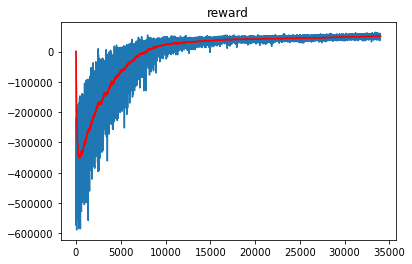

i_episode 35000
mu tensor([ 0.5191, -1.3133], grad_fn=<AddBackward0>) sigma tensor([0.2626, 0.2127], grad_fn=<AddBackward0>)
i_episode 35000
mu tensor([-0.0088, -1.0313], grad_fn=<AddBackward0>) sigma tensor([0.0326, 0.0723], grad_fn=<AddBackward0>)
i_episode 35000
mu tensor([ 0.4938, -0.1770], grad_fn=<AddBackward0>) sigma tensor([0.0268, 0.0827], grad_fn=<AddBackward0>)
i_episode 35000
mu tensor([0.4563], grad_fn=<AddBackward0>) sigma tensor([0.9213], grad_fn=<AddBackward0>)
i_episode 35000
mu tensor([0.2327], grad_fn=<AddBackward0>) sigma tensor([0.8653], grad_fn=<AddBackward0>)
i_episode 35000
mu tensor([-1.7206], grad_fn=<AddBackward0>) sigma tensor([0.1723], grad_fn=<AddBackward0>)
statevalue 1.7228349447250366
statevalue 1.4228668212890625
statevalue 0.437598317861557
statevalue -0.07044953107833862
statevalue -0.8410149812698364
statevalue -0.9054183959960938
statevalue 1.398832082748413
statevalue 1.356270670890808
statevalue 0.2838836908340454
statevalue -0.030133038759231567

pow_pen [-0. -0. -0. -0. -0. -0. -0. -0.]
SoC [ 0.          6.15200251  1.13785602  0.         20.99065483  8.70034695
  0.          2.20123809]
solar [ 4.51581786 28.97051423 45.78399352 55.54542732 54.00409595 45.79190277
 31.47947406  5.85779096]
pb [ 99.8690784   54.08957601  34.72944498 -23.31849486 -65.51603079
 -53.38004231 -63.92363906   9.42809805]
f_pb [ 99.8690784   54.08957601  34.72944498 -23.31849486 -65.51603079
 -53.38004231 -46.47353142   9.42809805]
power [ 10.4657778    0.          32.54233869 170.39651144 129.95351997
 350.82805492 359.84982012 259.76061909]
f_power [ 10.4657778    0.          32.54233869 170.39651144 129.95351997
 350.82805492 359.84982012 259.76061909]
demand [ 10.86885132  70.55224924  79.73269487 280.35350055 302.15862138
 450.         497.80881229 356.19031199]
price [31.52185811 34.08353285 28.37788419  3.27441658  7.9735631   0.
  0.36519795  7.30161467]
f_price [31.52185811 18.24129179 28.37788419  3.27441658  7.9735631   0.
  0.36519795  7.

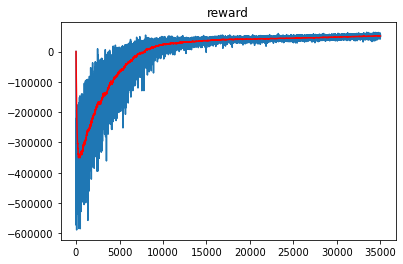

printing new best model 63699.82891217587


Episode: 35048, reward: 63699.82891217587
mean 51342.28685856347
mean_n1 25486.556439875443
mean_n2 20178.212802850874
mean_n3 5677.51761583714
reward_episode_score_n1: 20665.335251097753
reward_episode_score_n2: 27887.65874558882
reward_episode_score_n3: 15146.83491548931
reward_episode_score_T12: 0.0
reward_episode_score_T13: -2332.9049131240795
reward_episode_score_T23: -2332.9049131240795
solar [ 4.31038606 28.61665099 45.01263546 54.27120779 54.05623657 45.66809912
 30.62731079  4.99175641]
pb [  96.65382504  120.00888586   49.78964329    3.19464058   -2.35466808
  -64.6510005  -107.89809227  -62.10398674]
f_pb [  96.65382504  120.00888586   49.78964329    3.19464058   -2.35466808
  -64.6510005  -107.89809227  -62.10398674]
power [380.02166581 408.97001    396.73809363 409.00826153 439.63782596
 450.46392451 561.39859804 505.48855957]
f_power [380.02166581 408.97001    396.73809363 409.00826153 439.63782596
 450.46392451 561.39859804 505

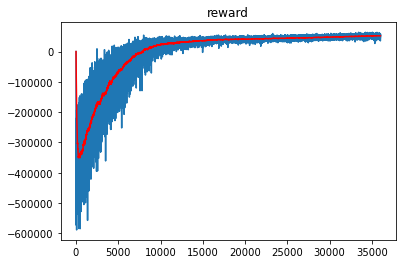



Episode: 37000, reward: 50811.049241746405
mean 51575.82288995336
mean_n1 26293.52452359139
mean_n2 20317.7352175304
mean_n3 4964.563148831563
reward_episode_score_n1: 24242.14484242852
reward_episode_score_n2: 24861.714948276604
reward_episode_score_n3: 1707.1894510412794
reward_episode_score_T12: -14.301204255908136
reward_episode_score_T13: -1736.8896956587987
reward_episode_score_T23: -1895.849791836236
solar [ 5.3175204  28.41505832 46.40802649 54.31130361 54.88231194 46.99693674
 29.7824824   5.83162917]
pb [ 168.25811863  102.57320404   13.0873993     5.26891053  -11.6607219
  -73.62623215 -139.29401636   53.12441587]
f_pb [ 168.25811863  102.57320404    9.16867733    0.          -11.6607219
  -73.62623215 -139.29401636   53.12441587]
power [461.0706381  341.84460246 335.10550829 345.49557734 374.46038562
 450.18937832 367.24544523 600.        ]
f_power [461.0706381  341.84460246 335.10550829 345.49557734 374.46038562
 450.18937832 367.24544523 600.        ]
demand [200.      

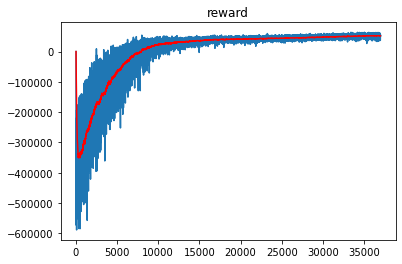



Episode: 38000, reward: 54124.710098783034
mean 52584.40836375247
mean_n1 26757.52585222482
mean_n2 20174.356836005092
mean_n3 5652.525675522559
reward_episode_score_n1: 25081.745612828207
reward_episode_score_n2: 22257.018337696394
reward_episode_score_n3: 6785.946148258433
reward_episode_score_T12: -14.290325044150903
reward_episode_score_T13: -2674.341546498729
reward_episode_score_T23: -2630.668552121411
solar [ 6.32268832 29.12447282 48.45933172 53.19242518 56.66803063 47.06819173
 28.63359905  4.00437539]
pb [ 155.70124388  108.93411636   10.06430462   20.15295625   -6.95421621
  -68.81016493 -133.7603569   -17.07598716]
f_pb [ 155.70124388  108.93411636   10.06430462    5.30033514   -6.95421621
  -68.81016493 -133.7603569   -17.07598716]
power [462.14251324 360.78529111 284.80588865 298.18043325 453.86622085
 489.59102068 348.07078683 507.39690761]
f_power [462.14251324 360.78529111 284.80588865 298.18043325 453.86622085
 489.59102068 348.07078683 507.39690761]
demand [200.   

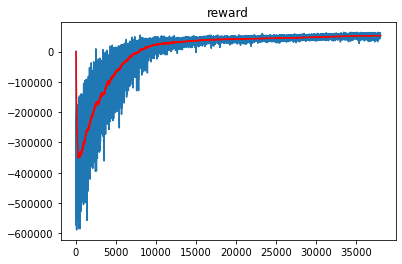



Episode: 39000, reward: 53919.08223266845
mean 52842.48051722962
mean_n1 26410.929987435535
mean_n2 20105.631651630436
mean_n3 6325.918878163635
reward_episode_score_n1: 27290.892097850465
reward_episode_score_n2: 20408.936174693918
reward_episode_score_n3: 6219.253960124059
reward_episode_score_T12: -319.0691548746066
reward_episode_score_T13: -1693.7792630402894
reward_episode_score_T23: -1956.470555311566
solar [ 5.68655634 30.71529179 44.49967087 51.21781141 54.02891108 47.07076647
 28.55725078  6.39627346]
pb [ 105.50570488  144.79079247   25.61515868   12.96425462   -7.16599897
  -70.80719471 -136.25313044  -54.18943167]
f_pb [ 105.50570488  144.79079247   25.61515868    4.08834398   -7.16599897
  -70.80719471 -136.25313044  -54.18943167]
power [422.51058316 228.29584301 343.97879004 382.05305009 417.94022477
 424.87995527 367.24073502 467.66418672]
f_power [422.51058316 228.29584301 343.97879004 382.05305009 417.94022477
 424.87995527 367.24073502 467.66418672]
demand [200.   

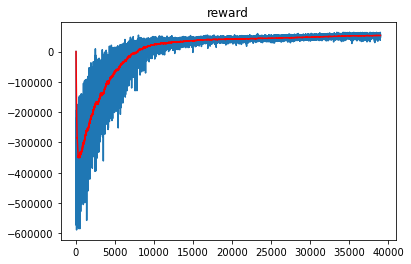

printing new best model 64312.19453691533


Episode: 39029, reward: 64312.19453691533
mean 53373.943728678525
mean_n1 26112.656262689572
mean_n2 20735.559945676174
mean_n3 6525.727520312769
reward_episode_score_n1: 20207.228333477542
reward_episode_score_n2: 29448.316032695722
reward_episode_score_n3: 14656.650170742072
reward_episode_score_T12: -1.5740013144110998
reward_episode_score_T13: -2210.5928594775637
reward_episode_score_T23: -2226.7633524076123
solar [ 4.74913065 27.90806501 45.81207991 55.76911739 54.13194604 44.03399401
 29.82928848  5.58324218]
pb [  23.99522662  155.5316925    96.65555954   13.40376139    0.99735595
  -67.4700737  -130.58030605  -78.51320505]
f_pb [  23.99522662  155.5316925    96.65555954    3.81752133    0.
  -67.4700737  -130.58030605  -78.51320505]
power [389.18249663 467.89604098 351.06917858 358.08820733 469.22819756
 491.00745595 508.69450921 505.86681604]
f_power [389.18249663 467.89604098 351.06917858 358.08820733 469.22819756
 491.00745595 508.

pow_pen [-0. -0. -0. -0. -0. -0. -0. -0.]
SoC [116.52261019 202.16100812 225.87876618 164.40799534 135.85989773
  87.23880351   2.14242637   3.16374823]
f_tvol [ 73.58563542  72.50324786   0.          68.12431663  41.18110538
  52.61053406  65.73698819 100.        ]
reward [ -0.         -17.50077676  -0.65681767  -0.          -0.
  -4.15593471  -0.          -0.        ]
f_tvol [84.13506746 76.83346272  0.          0.         73.59924912 48.92367572
 59.27941799 27.53533572]
reward [-1049.4214354   -458.1139847    -45.37545776    -5.02300622
   -65.98826718   -13.58147019    -0.           -85.3647848 ]
f_tvol [ 0.          4.76713777 18.70337129 11.26538813  1.23269856  0.
  0.          0.        ]
reward [-1049.4214354   -654.69407992   -35.11377694    -5.02300622
   -65.98826718    -2.71159998    -0.           -85.3647848 ]


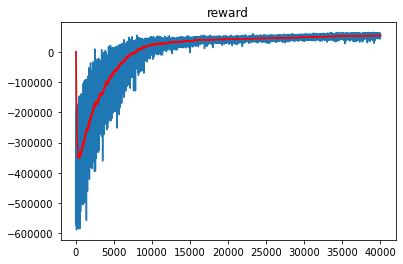



Episode: 41000, reward: 53442.48389057323
mean 54011.21820333215
mean_n1 26518.158839746065
mean_n2 20544.100441806488
mean_n3 6948.9589217795965
reward_episode_score_n1: 28803.326609347998
reward_episode_score_n2: 14419.659900996721
reward_episode_score_n3: 10219.497380228519
reward_episode_score_T12: -0.6222162706107877
reward_episode_score_T13: -2013.9406459393215
reward_episode_score_T23: -2014.5628622099323
solar [ 4.84409488 29.38404822 47.47379091 52.99116586 52.53612599 46.07970915
 29.12062442  4.35514177]
pb [  76.37331486  177.57601738   29.75677848   12.34803945   -9.24591571
  -62.02830672 -130.87534904 -122.76756763]
f_pb [  76.37331486  177.57601738   26.05066776    0.           -9.24591571
  -62.02830672 -130.87534904  -77.85042852]
power [407.38170662 328.19196916 320.95134322 298.83498337 429.1551704
 345.9861795  420.26612016 443.22443401]
f_power [407.38170662 328.19196916 320.95134322 298.83498337 429.1551704
 345.9861795  420.26612016 443.22443401]
demand [200. 

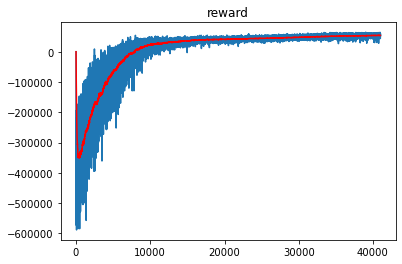

printing new best model 68500.95205030231


Episode: 41092, reward: 68500.95205030231
mean 54124.86392441179
mean_n1 27060.20013833194
mean_n2 19034.77344265771
mean_n3 8029.89034342214
reward_episode_score_n1: 21610.104054641983
reward_episode_score_n2: 27607.57554613027
reward_episode_score_n3: 19283.272449530057
reward_episode_score_T12: -1.2463875978180763
reward_episode_score_T13: -2272.66185163613
reward_episode_score_T23: -2296.1903933875283
solar [ 6.2224277  27.58383912 45.48391961 54.48169846 54.7088825  47.19670506
 28.23145787  5.84958634]
pb [  56.25865459  136.60806417   68.77023578   18.00560504    4.8031643
  -62.66492605 -139.29886818  -72.69202471]
f_pb [  56.25865459  136.60806417   68.77023578   18.00560504    0.35744041
  -62.66492605 -139.29886818  -72.69202471]
power [318.09499778 394.10814958 395.80924548 324.25553512 473.37027587
 535.09282378 522.25512763 499.11139765]
f_power [318.09499778 394.10814958 395.80924548 324.25553512 473.37027587
 535.09282378 522.

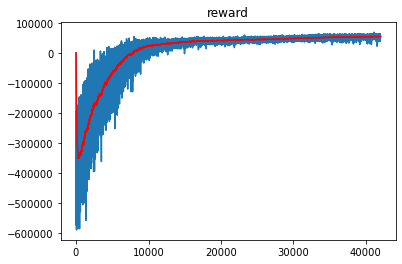



Episode: 43000, reward: 55991.53698918448
mean 54422.17723699756
mean_n1 27680.522902772827
mean_n2 19028.30606930714
mean_n3 7713.348264917601
reward_episode_score_n1: 27959.264303206495
reward_episode_score_n2: 21859.74399267077
reward_episode_score_n3: 6172.528693307213
reward_episode_score_T12: -2.344477270085462
reward_episode_score_T13: -2147.895275240323
reward_episode_score_T23: -2070.84426285258
solar [ 6.55673482 32.54525814 44.15070805 54.58480557 53.70508614 44.41026907
 28.88059686  3.53635621]
pb [ 131.91874027  110.56796312   32.45618343    8.46345276   -5.7881061
  -65.1825428  -135.86047888  -64.75191712]
f_pb [ 131.91874027  110.56796312   32.45618343    5.05711317   -5.7881061
  -65.1825428  -135.86047888  -64.75191712]
power [475.27774535 328.4020203  325.55234339 350.4723076  290.50680776
 440.40718813 447.14359162 484.25119038]
f_power [475.27774535 328.4020203  325.55234339 350.4723076  290.50680776
 440.40718813 447.14359162 484.25119038]
demand [200.         

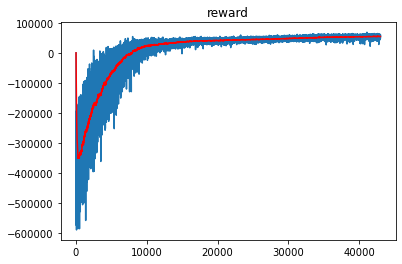



Episode: 44000, reward: 55554.32050237258
mean 54689.34423123622
mean_n1 27809.910923656058
mean_n2 19122.585630189707
mean_n3 7756.847677390446
reward_episode_score_n1: 28745.07115846788
reward_episode_score_n2: 19071.04369538031
reward_episode_score_n3: 7738.2056485243975
reward_episode_score_T12: -0.22878198963073124
reward_episode_score_T13: -2195.2333949097165
reward_episode_score_T23: -2222.8101455772126
solar [ 4.47304209 30.11022552 46.60182463 56.07405722 56.24215286 45.53159522
 28.80119071  3.19993586]
pb [  95.52443027  167.47145653   23.50875884    9.30391476    1.3476206
  -61.29345894 -135.0161314   -77.87556648]
f_pb [  95.52443027  167.47145653   17.0041132     0.            0.
  -61.29345894 -135.0161314   -77.87556648]
power [427.65651236 411.71031134 288.89120532 343.92594278 415.26080091
 430.76913608 369.28672358 419.92069095]
f_power [427.65651236 411.71031134 288.89120532 343.92594278 415.26080091
 430.76913608 369.28672358 419.92069095]
demand [200.         1

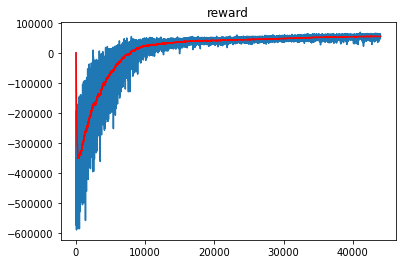

i_episode 45000
mu tensor([ 0.4275, -1.2979], grad_fn=<AddBackward0>) sigma tensor([0.1468, 0.1611], grad_fn=<AddBackward0>)
i_episode 45000
mu tensor([-0.0082, -1.0156], grad_fn=<AddBackward0>) sigma tensor([0.0239, 0.0586], grad_fn=<AddBackward0>)
i_episode 45000
mu tensor([ 0.7262, -0.1236], grad_fn=<AddBackward0>) sigma tensor([0.0147, 0.0463], grad_fn=<AddBackward0>)
i_episode 45000
mu tensor([0.4597], grad_fn=<AddBackward0>) sigma tensor([0.9212], grad_fn=<AddBackward0>)
i_episode 45000
mu tensor([0.2344], grad_fn=<AddBackward0>) sigma tensor([0.8706], grad_fn=<AddBackward0>)
i_episode 45000
mu tensor([-1.7416], grad_fn=<AddBackward0>) sigma tensor([0.1682], grad_fn=<AddBackward0>)
statevalue 1.9001927375793457
statevalue 1.393494725227356
statevalue 0.6685827374458313
statevalue -0.004814773797988892
statevalue -0.9286952018737793
statevalue -0.9515922665596008
statevalue 1.4472287893295288
statevalue 1.3357683420181274
statevalue 0.3732263445854187
statevalue -0.023752897977828

pow_pen [-0. -0. -0. -0. -0. -0. -0. -0.]
SoC [145.56332827 239.7891283  234.05989856 270.18015832 176.84782594
 101.00042075   0.           1.62853748]
f_tvol [ 25.23454726 100.           0.         100.          21.71308994
  12.35744357  46.32029422  52.51787305]
reward [ -1.75627702  -6.5589696   -0.          -0.          -0.
 -28.09219624 -40.12543667  -0.        ]
f_tvol [49.92557168 38.51322979 23.60336185  0.         13.29491436 67.21699238
 42.12611094 48.67456071]
reward [-1.11111111e+03 -6.57997330e+02 -3.50991643e+01 -4.40084378e+01
 -9.69949818e-01 -0.00000000e+00 -0.00000000e+00 -8.17287668e+01]
f_tvol [ 0.          0.         23.43421578 45.72011232 40.14303982 24.25732017
  0.          0.        ]
reward [-1.02451765e+03 -5.33167039e+02 -3.50991643e+01 -4.40084378e+01
 -9.69949818e-01 -2.80921962e+01 -4.01254367e+01 -8.17287668e+01]


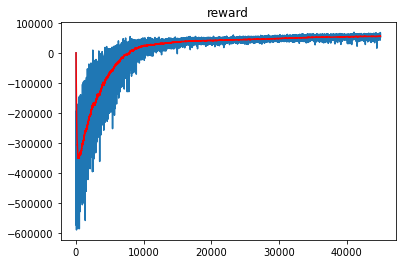



Episode: 46000, reward: 51685.997315467146
mean 55749.636831348274
mean_n1 27486.911838082808
mean_n2 18599.849158347566
mean_n3 9662.875834917895
reward_episode_score_n1: 28389.128565358264
reward_episode_score_n2: 18925.71527585698
reward_episode_score_n3: 4371.153474251901
reward_episode_score_T12: -68.64925088231479
reward_episode_score_T13: -1488.0130797606048
reward_episode_score_T23: -1744.1625346980898
solar [ 4.69882606 29.00834848 45.49059533 52.43086774 53.2976523  46.27417834
 27.63688804  5.25301842]
pb [ 103.23939323  126.02319717   31.17624521   15.53503275    3.5409648
  -64.94474411 -139.50542212  -56.17438555]
f_pb [ 103.23939323  126.02319717   31.17624521   15.53503275    3.5409648
  -64.94474411 -139.50542212  -56.17438555]
power [434.57605572 405.63907932 295.29054946 370.51063221 387.66720333
 406.17562025 363.52717636 418.32724066]
f_power [434.57605572 405.63907932 295.29054946 370.51063221 387.66720333
 406.17562025 363.52717636 418.32724066]
demand [200.   

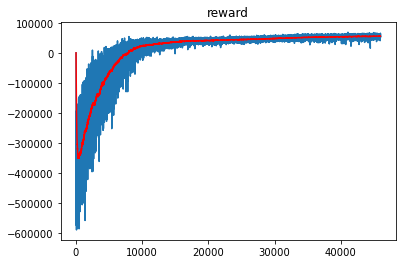



Episode: 47000, reward: 56083.08413201471
mean 55217.25337641106
mean_n1 28485.71055243453
mean_n2 18213.63632884398
mean_n3 8517.906495132544
reward_episode_score_n1: 28532.768332245265
reward_episode_score_n2: 19393.515797731
reward_episode_score_n3: 8156.800002038437
reward_episode_score_T12: -23.678603232450257
reward_episode_score_T13: -2026.2934407012588
reward_episode_score_T23: -2076.5354637559267
solar [ 5.11301192 30.23614334 45.45316333 54.65182624 54.03631126 45.74203591
 30.19654432  4.73070097]
pb [  92.52539277  120.38221359   55.29022217    9.13760066    1.67640448
  -65.45444131 -140.4556036   -25.58994889]
f_pb [  92.52539277  120.38221359   55.29022217    9.13760066    1.67640448
  -65.45444131 -140.4556036   -25.58994889]
power [426.62282405 344.08319278 317.73180579 354.48577442 308.52135624
 438.80352278 447.68733626 471.94650705]
f_power [426.62282405 344.08319278 317.73180579 354.48577442 308.52135624
 438.80352278 447.68733626 471.94650705]
demand [200.      

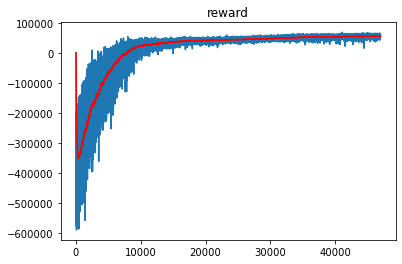



Episode: 48000, reward: 54679.51706788576
mean 56564.01519856132
mean_n1 27828.805152286324
mean_n2 18946.819840821096
mean_n3 9788.390205453885
reward_episode_score_n1: 29220.995303450207
reward_episode_score_n2: 17906.253857055206
reward_episode_score_n3: 7552.267907380356
reward_episode_score_T12: -24.905584703366646
reward_episode_score_T13: -2002.7865507972238
reward_episode_score_T23: -2233.48105181788
solar [ 6.71559312 30.0530819  46.57913751 56.81543414 52.79365087 45.10118668
 30.25659186  6.13105367]
pb [  82.98282623  141.05991125   34.90105569   22.03448564   -0.72843125
  -67.37114191 -140.33389091  -72.47903943]
f_pb [  82.98282623  141.05991125   34.90105569   21.05620682   -0.72843125
  -67.37114191 -140.33389091  -71.56653592]
power [394.62548605 407.87329128 338.32191819 303.90725251 296.47791788
 439.66447706 452.71058033 409.79540537]
f_power [394.62548605 407.87329128 338.32191819 303.90725251 296.47791788
 439.66447706 452.71058033 409.79540537]
demand [200.   

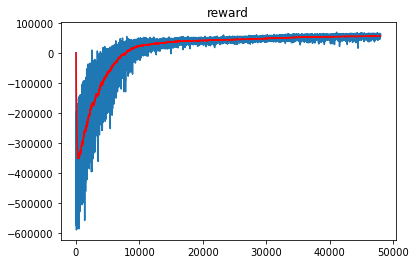



Episode: 49000, reward: 63007.42036717041
mean 55656.08122139937
mean_n1 28437.192167399135
mean_n2 18176.5502088467
mean_n3 9042.338845153545
reward_episode_score_n1: 23914.146808906666
reward_episode_score_n2: 25769.216097903118
reward_episode_score_n3: 13324.057460360622
reward_episode_score_T12: -0.00024116237885894596
reward_episode_score_T13: -2085.1712842210923
reward_episode_score_T23: -2084.23976116228
solar [ 3.72673412 29.66373911 44.56513612 53.29957859 54.32920966 48.56790925
 28.61742576  4.90632614]
pb [  80.90465665  146.75312042   40.13838172   18.67928058    0.2478837
  -64.25099969 -139.68839645  -63.49286437]
f_pb [  80.90465665  146.75312042   40.13838172   12.20384121    0.
  -64.25099969 -139.68839645  -63.49286437]
power [449.92304902 412.74577656 293.01870378 358.90426262 359.90441825
 499.24791133 462.88808534 526.37678424]
f_power [449.92304902 412.74577656 293.01870378 358.90426262 359.90441825
 499.24791133 462.88808534 526.37678424]
demand [200. 180. 250

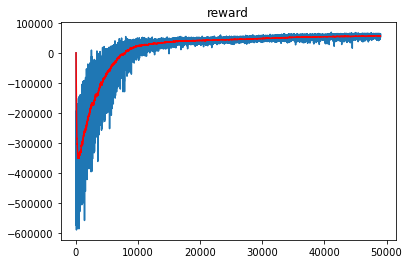

i_episode 50000
mu tensor([ 0.4089, -1.2861], grad_fn=<AddBackward0>) sigma tensor([0.1180, 0.1449], grad_fn=<AddBackward0>)
i_episode 50000
mu tensor([-0.0152, -1.0098], grad_fn=<AddBackward0>) sigma tensor([0.0211, 0.0535], grad_fn=<AddBackward0>)
i_episode 50000
mu tensor([ 0.7268, -0.1389], grad_fn=<AddBackward0>) sigma tensor([0.0111, 0.0380], grad_fn=<AddBackward0>)
i_episode 50000
mu tensor([0.4619], grad_fn=<AddBackward0>) sigma tensor([0.9211], grad_fn=<AddBackward0>)
i_episode 50000
mu tensor([0.2350], grad_fn=<AddBackward0>) sigma tensor([0.8749], grad_fn=<AddBackward0>)
i_episode 50000
mu tensor([-1.7508], grad_fn=<AddBackward0>) sigma tensor([0.1667], grad_fn=<AddBackward0>)
statevalue 1.798541784286499
statevalue 1.3311482667922974
statevalue 0.7622924447059631
statevalue -0.04483979940414429
statevalue -1.0042530298233032
statevalue -1.0389997959136963
statevalue 1.4841355085372925
statevalue 1.2795462608337402
statevalue 0.4947398900985718
statevalue -0.0339993983507156

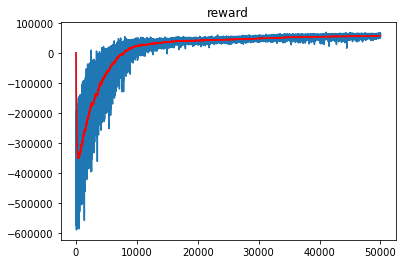



Episode: 51000, reward: 61993.70084431256
mean 56277.02581757001
mean_n1 28826.555950932172
mean_n2 18278.275440593643
mean_n3 9172.194426044181
reward_episode_score_n1: 23659.25104588183
reward_episode_score_n2: 26466.75064233206
reward_episode_score_n3: 11867.699156098668
reward_episode_score_T12: -272.7043301454507
reward_episode_score_T13: -1475.1388024158998
reward_episode_score_T23: -2105.6876943592283
solar [ 5.79196893 30.08152378 46.35186037 54.86038297 54.80581847 46.25837488
 30.71931674  4.59159929]
pb [  84.89656448  145.09414434   46.65836096   14.04793262    1.09522976
  -62.43482828 -135.70964336 -108.97526741]
f_pb [  84.89656448  145.09414434   46.65836096    3.35093021    0.
  -62.43482828 -135.70964336  -81.85552835]
power [376.46601267 223.85277199 316.79652939 345.02062708 395.19418153
 541.13934653 464.45986555 488.75014287]
f_power [376.46601267 223.85277199 316.79652939 345.02062708 395.19418153
 541.13934653 464.45986555 488.75014287]
demand [200.          4

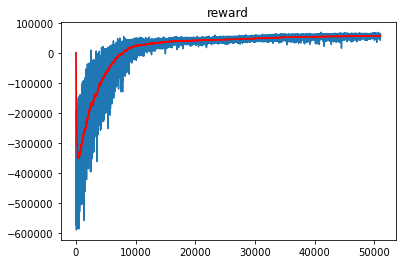


KeyboardInterrupt



In [ ]:
max_score = 30000
stats,n1_stats,n2_stats,n3_stats,nT12_stats = [],[],[],[],[]

for i_episode in range(cfg.max_episode):
    state_n1,state_n2,state_n3,state_tn12,state_tn13,state_tn23= env.reset()
    episode_score = 0
    episode_score_n1 = 0
    episode_score_n2 = 0
    episode_score_n3 = 0
    episode_score_Tn1 = 0
    episode_score_Tn2 = 0
    episode_score_Tn3 = 0

    path_n1,path_n1b,path_n2,path_n2b,path_n3,path_n3b,path_tn12,path_tn13,path_tn23 = [],[],[],[],[],[],[],[],[]

    for t in count():
        action_n1 = get_action_node(state_n1,i_episode,actor_node1)
        action_n2 = get_action_node(state_n2,i_episode,actor_node2)
        action_n3 = get_action_node(state_n3,i_episode,actor_node3)
        action_tn12 = get_action_tnode(state_tn12,i_episode,actor_tnode12)
        action_tn13 = get_action_tnode(state_tn13,i_episode,actor_tnode13)
        action_tn23 = get_action_tnode(state_tn23,i_episode,actor_tnode23)
        nextstates_,rewards_,time,done = env.step(action_n1,action_n2,action_n3,
                                                  action_tn12,action_tn13,action_tn23) 
        #states,rewards_,self.time_interval,False
        next_state_n1 = nextstates_[0]
        next_state_n2 = nextstates_[1]
        next_state_n3 = nextstates_[2]
        next_state_tn12 = nextstates_[3]
        next_state_tn13 = nextstates_[4]
        next_state_tn23 = nextstates_[5]
        
        reward_n1 = rewards_[0]
        reward_n2 = rewards_[1]
        reward_n3 = rewards_[2]
        reward_tn12 = rewards_[3]
        reward_tn13 = rewards_[4]
        reward_tn23 = rewards_[5]
        episode_score += (reward_n1/cfg.rewardScale_node1)+(reward_n2/cfg.rewardScale_node2)+(reward_n3/cfg.rewardScale_node3)
        episode_score_n1 += (reward_n1/cfg.rewardScale_node1)
        episode_score_n2 += (reward_n2/cfg.rewardScale_node2)
        episode_score_n3 += (reward_n3/cfg.rewardScale_node3)
        episode_score_Tn1 += (reward_tn12/cfg.rewardScale_tnode12)
        episode_score_Tn2 += (reward_tn13/cfg.rewardScale_tnode13)
        episode_score_Tn3 += (reward_tn23/cfg.rewardScale_tnode23)
        
        if done:
            target_n1 = reward_n1
            target_n2 = reward_n2
            target_n3 = reward_n3
            target_tn12 = reward_tn12
            target_tn13 = reward_tn13
            target_tn23 = reward_tn23
        else:
            target_n1 = reward_n1 + cfg.gamma * get_state_value_node(next_state_n1,i_episode,critic_node1)
            target_n2 = reward_n2 + cfg.gamma * get_state_value_node(next_state_n2,i_episode,critic_node2)
            target_n3 = reward_n3 + cfg.gamma * get_state_value_node(next_state_n3,i_episode,critic_node3)
            target_tn12 = reward_tn12 + cfg.gamma * get_state_value_tnode(next_state_tn12,i_episode,critic_tnode12)
            target_tn13 = reward_tn13 + cfg.gamma * get_state_value_tnode(next_state_tn13,i_episode,critic_tnode13)
            target_tn23 = reward_tn23 + cfg.gamma * get_state_value_tnode(next_state_tn23,i_episode,critic_tnode23)
        
        td_error_n1 = target_n1 - get_state_value_node(state_n1,i_episode,critic_node1)
        td_error_n2 = target_n2 - get_state_value_node(state_n2,i_episode,critic_node2)
        td_error_n3 = target_n3 - get_state_value_node(state_n3,i_episode,critic_node3)
        td_error_tn12 = target_tn12 - get_state_value_tnode(state_tn12,i_episode,critic_tnode12)
        td_error_tn13 = target_tn13 - get_state_value_tnode(state_tn13,i_episode,critic_tnode13)
        td_error_tn23 = target_tn23 - get_state_value_tnode(state_tn23,i_episode,critic_tnode23)
        
        update_actor_node(state_n1, action_n1, td_error_n1,actor_node1,actor_optimizer_node1)
        update_critic_node(state_n1, target_n1,critic_node1,critic_optimizer_node1)
        
        update_actor_node(state_n2, action_n2, td_error_n2,actor_node2,actor_optimizer_node2)
        update_critic_node(state_n2, target_n2,critic_node2,critic_optimizer_node2)
        
        update_actor_node(state_n3, action_n3, td_error_n3,actor_node3,actor_optimizer_node3)
        update_critic_node(state_n3, target_n3,critic_node3,critic_optimizer_node3)
        
        if i_episode%cfg.TUpdate == 0:
            update_actor_tnode(state_tn12, action_tn12, td_error_tn12,actor_tnode12,actor_optimizer_tnode12)
            update_critic_tnode(state_tn12, target_tn12,critic_tnode12,critic_optimizer_tnode12)
            
            update_actor_tnode(state_tn13, action_tn13, td_error_tn13,actor_tnode13,actor_optimizer_tnode13)
            update_critic_tnode(state_tn13, target_tn13,critic_tnode13,critic_optimizer_tnode13)
            
            update_actor_tnode(state_tn23, action_tn23, td_error_tn23,actor_tnode23,actor_optimizer_tnode23)
            update_critic_tnode(state_tn23, target_tn23,critic_tnode23,critic_optimizer_tnode23)
            
    
        if done:
            avg_score_plot.append(avg_score_plot[-1] * 0.99 + episode_score * 0.01)
            last_score_plot.append(episode_score)
            #drawnow(draw_fig)
            break
    
        state_n1 = next_state_n1
        state_n2 = next_state_n2
        state_n3 = next_state_n3
        state_tn12 = next_state_tn12
        state_tn13 = next_state_tn13
        state_tn23 = next_state_tn23
        
    stats.append(episode_score)
    n1_stats.append(episode_score_n1)
    n2_stats.append(episode_score_n2)
    n3_stats.append(episode_score_n3)
    nT12_stats.append(episode_score_Tn1)

    #reduce LR every:
    
    
    if i_episode%2000 == 0:
        actor_scheduler_tnode12.step()
        critic_scheduler_tnode12.step()
        actor_scheduler_tnode13.step()
        critic_scheduler_tnode13.step()
        actor_scheduler_tnode23.step()
        critic_scheduler_tnode23.step()
    
    
    if i_episode%2000 == 0:
        actor_scheduler_node1.step()
        critic_scheduler_node1.step()
        actor_scheduler_node2.step()
        critic_scheduler_node2.step()
        actor_scheduler_node3.step()
        critic_scheduler_node3.step()
    
    #print data every:
    if (i_episode)% 1000 == 0:
        print('\n')
        print('Episode: {}, reward: {}'.format(i_episode, episode_score))
        print('mean',np.mean(stats[-100:]))
        print('mean_n1',np.mean(n1_stats[-100:]))
        print('mean_n2',np.mean(n2_stats[-100:]))
        print('mean_n3',np.mean(n3_stats[-100:]))
        print('reward_episode_score_n1: {}'.format(episode_score_n1))
        print('reward_episode_score_n2: {}'.format(episode_score_n2))
        print('reward_episode_score_n3: {}'.format(episode_score_n3))
        print('reward_episode_score_T12: {}'.format(episode_score_Tn1))
        print('reward_episode_score_T13: {}'.format(episode_score_Tn2))
        print('reward_episode_score_T23: {}'.format(episode_score_Tn3))
        path_n1 = np.transpose(path_n1)
        path_n1b = np.transpose(path_n1b)
        path_n2 = np.transpose(path_n2)
        path_n2b = np.transpose(path_n2b)
        path_n3 = np.transpose(path_n3)
        path_n3b = np.transpose(path_n3b)
        path_tn12 = np.transpose(path_tn12)
        path_tn13 = np.transpose(path_tn13)
        path_tn23 = np.transpose(path_tn23)
        res = "\n".join("{} {}".format(x, y) for x, y in zip(keys_, path_n1))
        print(res)
        res = "\n".join("{} {}".format(x, y) for x, y in zip(keys_2, path_n1b))
        print(res)
        res = "\n".join("{} {}".format(x, y) for x, y in zip(keys_, path_n2))
        print(res)
        res = "\n".join("{} {}".format(x, y) for x, y in zip(keys_2, path_n2b))
        print(res)
        res = "\n".join("{} {}".format(x, y) for x, y in zip(keys_, path_n3))
        print(res)
        res = "\n".join("{} {}".format(x, y) for x, y in zip(keys_2, path_n3b))
        print(res)
        res = "\n".join("{} {}".format(x, y) for x, y in zip(keys_1, path_tn12))
        print(res)
        res = "\n".join("{} {}".format(x, y) for x, y in zip(keys_1, path_tn13))
        print(res)
        res = "\n".join("{} {}".format(x, y) for x, y in zip(keys_1, path_tn23))
        print(res)
        drawnow(draw_fig)


    if episode_score > max_score:
        print('printing new best model',episode_score)
        max_score = episode_score
        print('\n')
        print('Episode: {}, reward: {}'.format(i_episode, episode_score))
        print('mean',np.mean(stats[-100:]))
        print('mean_n1',np.mean(n1_stats[-100:]))
        print('mean_n2',np.mean(n2_stats[-100:]))
        print('mean_n3',np.mean(n3_stats[-100:]))
        print('reward_episode_score_n1: {}'.format(episode_score_n1))
        print('reward_episode_score_n2: {}'.format(episode_score_n2))
        print('reward_episode_score_n3: {}'.format(episode_score_n3))
        print('reward_episode_score_T12: {}'.format(episode_score_Tn1))
        print('reward_episode_score_T13: {}'.format(episode_score_Tn2))
        print('reward_episode_score_T23: {}'.format(episode_score_Tn3))
        path_n1 = np.transpose(path_n1)
        path_n1b = np.transpose(path_n1b)
        path_n2 = np.transpose(path_n2)
        path_n2b = np.transpose(path_n2b)
        path_n3 = np.transpose(path_n3)
        path_n3b = np.transpose(path_n3b)
        path_tn12 = np.transpose(path_tn12)
        path_tn13 = np.transpose(path_tn13)
        path_tn23 = np.transpose(path_tn23)
        res = "\n".join("{} {}".format(x, y) for x, y in zip(keys_, path_n1))
        print(res)
        res = "\n".join("{} {}".format(x, y) for x, y in zip(keys_2, path_n1b))
        print(res)
        res = "\n".join("{} {}".format(x, y) for x, y in zip(keys_, path_n2))
        print(res)
        res = "\n".join("{} {}".format(x, y) for x, y in zip(keys_2, path_n2b))
        print(res)
        res = "\n".join("{} {}".format(x, y) for x, y in zip(keys_, path_n3))
        print(res)
        res = "\n".join("{} {}".format(x, y) for x, y in zip(keys_2, path_n3b))
        print(res)
        
        res = "\n".join("{} {}".format(x, y) for x, y in zip(keys_1, path_tn12))
        print(res)
        res = "\n".join("{} {}".format(x, y) for x, y in zip(keys_1, path_tn13))
        print(res)
        res = "\n".join("{} {}".format(x, y) for x, y in zip(keys_1, path_tn23))
        print(res)
        

In [ ]:
stats.sort()
stats[-10:]